# Mini-Project 01 - Implementing a Conditional GAN

Advanced Topics in Deep Learning

---

**António Cruz** (140129), **Cátia Brás** (120093), **Ricardo Kayseller** (95813)

# 1. Introduction

---

Generative Adversarial Networks (GANs) have become a fundamental class of generative models for learning complex data distributions and synthesizing realistic samples. In the classical (unconditional) GAN framework, the generator receives only random noise as input and learns to produce samples that resemble the training data, while the discriminator learns to distinguish real data from generated samples. Although this setting allows the model to generate realistic images, it provides no control over the semantic content of the generated samples. In the context of datasets with labeled structure, such as MNIST, an unconditional GAN may generate any digit between 0 and 9, but the user cannot specify which digit should be produced.

Conditional Generative Adversarial Networks (cGANs) extend the original GAN formulation by incorporating additional side information, such as class labels, into both the generator and the discriminator. By conditioning the generation process on a label 𝑦, the generator learns a mapping 𝐺(𝑧,𝑦) that aims to produce samples consistent with the desired class, while the discriminator is trained to assess not only whether an image is real or fake, but also whether it matches the provided condition. This conditioning mechanism enables controlled generation and significantly increases the practical usefulness of GANs in applications where semantic attributes matter, such as digit synthesis, object class control, and, more generally, text-to-image generation.

In this project, we investigate the implementation and behavior of conditional GANs on the MNIST dataset of handwritten digits. Starting from an unconditional DCGAN baseline, we progressively introduce conditioning mechanisms that allow explicit control over the generated digit class. Beyond basic conditioning via concatenation of labels, we explore stabilization strategies inspired by the literature, such as Spectral Normalization applied to the discriminator, in order to mitigate training instabilities and mode collapse. The experimental analysis focuses on both qualitative and quantitative aspects, including visual inspection of generated samples, class-conditional control checks, intra-class diversity, and discriminator behavior during training.

The main objective of this work is to demonstrate that conditional adversarial training enables controllable image generation, to analyze the limitations of simple conditioning strategies, and to assess how architectural and training refinements improve stability, diversity, and label consistency. This study provides practical insights into the challenges of training cGANs and highlights the importance of appropriate conditioning and regularization techniques for achieving reliable class-conditional generation.

# 2. Environment Setup & Configuration

---

In [2]:
# Import required dependencies
import os, random, time
import time
import numpy as np
from copy import deepcopy
from abc import ABC, abstractmethod
from threading import Timer

import webbrowser
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torch.nn.utils import spectral_norm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

## 2.1 Global Variables and Training Hyperparameters

In [ ]:
# Global variables

SEED = 42

# Mode: True for cGAN (conditional), False for DCGAN (unconditional)
CONDITIONAL = True

LIVE_MONITOR = False
LIVE_MONITOR_PORT_NUMBER = 8992
EMIT_INTERVAL = 1

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

# Path to calibrated classifier checkpoint
CLASSIFIER_CHECKPOINT = "classifier/model/mnist_cnn_best.ckpt"

# Example: NUM_STEPS = 15005 corresponds to ~32 epochs (60000 images / 128 batch_size ≈ 469 steps/epoch)
NUM_STEPS = 30010
SAVE_INTERVAL = 1000

# TTUR: Two Time-Scale Update Rule
# D learns faster than G, so we use different learning rates
LR_D = 4e-4  # Discriminator learning rate
LR_G = 1e-4  # Generator learning rate (4x slower)

# Adam betas optimized for GAN training
# Lower β1 (0.5 vs default 0.9) reduces momentum, stabilizes adversarial updates
ADAM_BETAS = (0.5, 0.999)

# Label smoothing for BCE/LSGAN (use 0.9 instead of 1.0 for real labels)
LABEL_SMOOTHING_REAL = 0.9

# WGAN-GP: number of critic steps per generator step
N_CRITIC = 5

# WGAN-GP: gradient penalty coefficient
LAMBDA_GP = 10.0

# Model output path includes mode subfolder (cgan or dcgan)
MODEL_OUTPUT_PATH = f"model/{'cgan' if CONDITIONAL else 'dcgan'}/"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

NUM_EVAL_SAMPLES = 10000

# Strategies to benchmark
BENCHMARK_STRATEGIES = ["bce", "lsgan", "hinge", "wgan-gp"]

## 2.2 Setup and Training Strategy

This project adopts a systematic experimental design to analyze the behavior and stability of conditional Generative Adversarial Networks (cGANs) on the MNIST dataset. Beyond implementing a single adversarial formulation, multiple loss strategies are benchmarked, including the standard binary cross-entropy (BCE) loss, Least Squares GAN (LSGAN), hinge loss, and Wasserstein GAN with Gradient Penalty (WGAN-GP). This design choice follows the theoretical and empirical insights discussed in the lecture materials on GAN losses and training stability, which highlight that different adversarial objectives lead to substantially different optimization dynamics, convergence behavior, and robustness to mode collapse. In particular, WGAN-GP is included due to its smoother loss landscape and explicit enforcement of the Lipschitz constraint, which is known to improve training stability compared to classical GAN formulations.

Training is performed using the Two Time-Scale Update Rule (TTUR), where the discriminator is updated with a learning rate four times higher than the generator (LR_D = 4×10⁻⁴, LR_G = 1×10⁻⁴). This choice is directly motivated by best practices discussed in the GAN training “recipe” guidelines, which emphasize that an overly weak discriminator fails to provide informative gradients to the generator, while an overly strong discriminator can lead to vanishing gradients. The Adam optimizer is used with β₁ = 0.5 and β₂ = 0.999, following the DCGAN and subsequent GAN literature, as these hyperparameters are empirically known to stabilize adversarial training by reducing excessive momentum in the discriminator updates.

The batch size is set to 128, representing a compromise between training stability and computational efficiency. Larger batch sizes generally provide more stable gradient estimates for both generator and discriminator, while still fitting comfortably within GPU memory constraints. The dimensionality of the latent space is fixed to 100, following common practice in DCGAN-style architectures, which provides sufficient capacity for modeling the variability of handwritten digits without introducing unnecessary complexity.

Training is defined in terms of a fixed number of optimization steps rather than epochs. Specifically, the model was trained for 30,010 steps. This value corresponds approximately to 64 epochs over the MNIST training set (MNIST contains 60,000 samples, and with a batch size of 128, one epoch corresponds to roughly 469 iterations). The step-based formulation is consistent with how GAN experiments are typically reported in the literature, as it provides finer control over the balance between generator and discriminator updates, enables predictable checkpointing and sampling intervals, and facilitates fair comparisons across different training configurations. The additional offset of five steps ensures that the final checkpoint aligns exactly with the predefined sampling interval of 1,000 steps, allowing the evolution of generated samples to be consistently monitored at fixed milestones throughout training.

## 2.3 Real-Time Monitoring Dashboard

In [3]:
if LIVE_MONITOR:
    from bin.gan_monitor import (
        start_server, emit_frames, emit_done,
        emit_benchmark_start, emit_strategy_start, emit_strategy_end
    )
    start_server(port=LIVE_MONITOR_PORT_NUMBER)

A real-time monitoring dashboard was developed and integrated into the training pipeline to support continuous inspection of adversarial dynamics during benchmarking. When enabled, a lightweight local server streams training diagnostics such as generator sample grids, discriminator and generator loss trajectories, and per-strategy progress markers. This design aligns with best-practice recommendations for GAN training, where losses alone are often insufficient to assess convergence or detect failure modes. The live monitor improves experimental transparency, facilitates early detection of mode collapse or imbalance between networks, and ensures consistent reporting across multiple loss strategies within the same benchmarking framework.  


In [4]:
# Set random seeds for reproducibility across both numpy and pytorch
random.seed(SEED)
np.random.seed(SEED) # to assure reproducibility on numpy (affects functions like np.random.rand, np.random.shuffle, etc.)
torch.manual_seed(SEED)  # to assure reproducibility on Torch (affects weight initialization, dropout, data shuffling, etc.)
torch.cuda.manual_seed_all(SEED) # usefull when using more than one GPT, otherwise torch.manual_seed is enough

# Ensure deterministic behavior in CuDNN (NVIDIA backend for deep learning ops).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 3. GAN Loss Strategies

---

In [6]:
# Loss Strategies

class GANLossStrategy(ABC):
    """Base class for GAN loss strategies."""
    use_sigmoid: bool = True
    use_label_smoothing: bool = False  # only BCE/LSGAN use this
    n_critic: int = 1  # D steps per G step
    smooth_real: float = 1.0
    
    @abstractmethod
    def d_loss_real(self, output: Tensor) -> Tensor:
        """Discriminator loss for real images."""
        pass
    
    @abstractmethod
    def d_loss_fake(self, output: Tensor) -> Tensor:
        """Discriminator loss for fake images."""
        pass
    
    @abstractmethod
    def g_loss(self, output: Tensor) -> Tensor:
        """Generator loss."""
        pass
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        """Gradient penalty (only used by WGAN-GP)."""
        return torch.tensor(0.0, device=real_imgs.device)
    
    def set_d_model(self, d_model) -> None:
        """Set discriminator reference (used by WGAN-GP)."""
        pass
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """Combine D losses. Override for strategy-specific formulas."""
        return 0.5 * (d_loss_real + d_loss_fake) + gp


class BCELossStrategy(GANLossStrategy):
    """Binary Cross-Entropy loss (original GAN) with label smoothing."""
    use_sigmoid = True
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.BCELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        # G wants D to output 1.0 (no smoothing for G)
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class LSGANLossStrategy(GANLossStrategy):
    """Least Squares loss with label smoothing."""
    use_sigmoid = False
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.MSELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class HingeLossStrategy(GANLossStrategy):
    """Hinge loss — used in SAGAN, BigGAN."""
    use_sigmoid = False
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 - output))
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 + output))
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)


class WGANGPLossStrategy(GANLossStrategy):
    """Wasserstein loss with gradient penalty."""
    use_sigmoid = False
    n_critic = 5  # train D 5 times per G step
    
    def __init__(self, lambda_gp: float = 10.0):
        self.d_model = None
        self.lambda_gp = lambda_gp
    
    def set_d_model(self, d_model) -> None:
        self.d_model = d_model
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(output)
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor = None) -> Tensor:
        if self.d_model is None:
            raise RuntimeError("d_model not set. Call set_d_model() first.")
        
        batch_size = real_imgs.size(0)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=real_imgs.device)
        interpolated = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        
        d_out = self.d_model(interpolated, labels)
        
        gradients = torch.autograd.grad(
            outputs=d_out,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_out),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        return self.lambda_gp * ((gradient_norm - 1) ** 2).mean()
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """WGAN-GP uses d_fake - d_real + gp (no 0.5 averaging)."""
        return d_loss_fake + d_loss_real + gp  # note: d_loss_real is already negated


def get_loss_strategy(name: str, device, lambda_gp: float = 10.0) -> GANLossStrategy:
    """Factory function to get loss strategy by name."""
    strategies = {
        "bce": BCELossStrategy,
        "lsgan": LSGANLossStrategy,
        "hinge": HingeLossStrategy,
        "wgan-gp": WGANGPLossStrategy,
    }
    if name not in strategies:
        raise ValueError(f"Unknown loss strategy: {name}. Options: {list(strategies.keys())}")
    
    if name == "bce":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    if name == "lsgan":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    if name == "wgan-gp":
        return strategies[name](lambda_gp=lambda_gp)
    return strategies[name]()


def get_discriminator(strategy_name: str, device):
    """
    Factory function to get strategy-appropriate Discriminator.
    
    WGAN-GP uses a specialized discriminator without spectral normalization
    or dropout, since the gradient penalty already enforces the Lipschitz
    constraint and stochasticity interferes with GP calculation.
    """
    if strategy_name == "wgan-gp":
        return DiscriminatorWGAN().to(device)
    else:
        use_sigmoid = (strategy_name == "bce")
        return Discriminator(use_sigmoid=use_sigmoid).to(device)


def get_adam_betas(strategy_name: str):
    """
    Get optimizer betas appropriate for each strategy.
    
    WGAN-GP uses beta1=0.0 for fresher gradient estimates without
    momentum interference, as recommended in the original paper.
    """
    if strategy_name == "wgan-gp":
        return (0.0, 0.9)
    else:
        return ADAM_BETAS  # (0.5, 0.999)

## 3.1 GAN Loss Strategies and Benchmarking Framework

In order to systematically study the impact of different adversarial objectives on training stability and sample quality, the training pipeline was designed around a modular loss-strategy framework. Instead of hard-coding a single GAN loss, a common abstract interface was defined to encapsulate the discriminator and generator loss components, enabling multiple loss formulations to be benchmarked under identical architectural and optimization conditions.

Four widely adopted loss strategies were implemented and evaluated:

1. **Binary Cross-Entropy (BCE) Loss**  
   This strategy corresponds to the original GAN formulation, where the discriminator is trained as a probabilistic classifier distinguishing real from generated samples. The generator is optimized to maximize the probability that fake samples are classified as real. To improve training stability, label smoothing is applied to real samples, reducing overconfidence in the discriminator and mitigating sharp gradients that may destabilize the adversarial dynamics. This formulation directly reflects the classical minimax game described in the original GAN literature.

2. **Least Squares GAN (LSGAN)**  
   The LSGAN objective replaces the binary cross-entropy loss with a least-squares regression loss. Instead of learning to output hard binary decisions, the discriminator is encouraged to regress towards continuous target values for real and fake samples. This formulation has been shown to reduce vanishing gradients and produce smoother optimization landscapes, often resulting in more stable convergence during training. As in the BCE strategy, label smoothing is applied to the real targets to further regularize the discriminator.

3. **Hinge Loss**  
   The hinge loss formulation adopts a margin-based objective, where the discriminator enforces a separation between real and fake samples using a hinge function. Rather than predicting explicit probabilities, the discriminator outputs real-valued scores, and the generator is trained to maximize these scores for generated samples. This loss is commonly used in modern high-performance GAN architectures and aligns with the design patterns discussed in contemporary GAN literature, particularly in combination with architectural constraints such as spectral normalization.

4. **Wasserstein GAN with Gradient Penalty (WGAN-GP)**  
   The WGAN-GP strategy reformulates the adversarial game in terms of the Wasserstein distance between the real and generated data distributions. Instead of a classifier, the discriminator acts as a critic that assigns scalar scores to samples. To enforce the required Lipschitz continuity constraint, a gradient penalty term is added, penalizing deviations of the gradient norm from unity along linear interpolations between real and fake samples. Additionally, the critic is updated multiple times per generator update, following the two time-scale update principle, to ensure a sufficiently strong approximation of the Wasserstein distance during training.

   Further experiments indicated that the degradation observed in the initial WGAN-GP configuration was strongly linked to the simultaneous application of multiple regularization mechanisms. In particular, the combination of Spectral Normalization and Gradient Penalty imposed redundant Lipschitz constraints on the Discriminator, while Dropout further reduced its effective capacity. In WGAN-GP, the discriminator is designed without spectral normalization or dropout, given that the gradient penalty already ensures the Lipschitz constraint, while stochastic components may interfere with the stability and reliability of the penalty term.

By implementing these loss strategies within a unified interface, the project enables a fair and controlled comparison of fundamentally different adversarial objectives. All strategies share the same generator and discriminator architectures, optimization settings, and training schedule, ensuring that observed differences in convergence behavior, stability, and sample quality can be attributed primarily to the choice of loss function rather than to confounding implementation details. This benchmarking setup reflects the theoretical and practical considerations emphasized in the course materials, where the choice of adversarial loss is a central factor in the stability and effectiveness of GAN training.


## 3.2 Software Architecture

To enable systematic benchmarking of multiple adversarial objectives and network configurations within a single codebase, the training framework was designed around two core software patterns:

- **Strategy Pattern**: All loss functions inherit from an abstract GANLossStrategy base class that defines a common interface (d_loss_real, d_loss_fake, g_loss, gradient_penalty). This allows BCE, LSGAN, Hinge, and WGAN-GP to be used interchangeably without modifying the training loop.

- **Factory Pattern**: The functions get_loss_strategy(), get_discriminator(), and get_adam_betas() instantiate the appropriate components based on the selected strategy. Notably, WGAN-GP uses a specialized DiscriminatorWGAN architecture (with LayerNorm, no Spectral Normalization or Dropout) since the gradient penalty already enforces the Lipschitz constraint.

- **Conditional Flag**: A global CONDITIONAL parameter switches between cGAN mode (label-conditioned generation) and standard DCGAN mode (unconditional). Both Generator and Discriminator classes accept an optional labels argument, enabling the same architecture to support both configurations.

![GAN Training Framework Software Architecture](images/gan_software_architecture.png)

**Figure 3.1** - Class architecture of the GAN training framework. The Strategy pattern enables interchangeable loss functions, while Factory functions create strategy-appropriate discriminators. The CONDITIONAL flag toggles between cGAN and DCGAN modes.

# 4. Data Loading

---

In [7]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


## 4.1 Data Loading and Preprocessing

MNIST images were converted to tensors and normalized to the range [-1, 1] using a mean of 0.5 and standard deviation of 0.5. This preprocessing step is required when the generator outputs images through a Tanh activation, ensuring that real and generated samples lie on the same numerical scale. The training split contains 60,000 images, and batching was performed with shuffling enabled. The DataLoader used drop_last=True to maintain a constant batch size across iterations, simplifying adversarial training dynamics and logging.


# 5. Generator & Discriminator

---

## 5.1 Conditional Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES, conditional=CONDITIONAL):
        super().__init__()
        self.conditional = conditional
        self.latent_dim = latent_dim
        
        if conditional:
            self.label_embedding = nn.Embedding(num_classes, latent_dim)

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
        )

        # Block 1: 7x7 -> 14x14
        self.conv1 = nn.Conv2d(128, 128 * 4, kernel_size=3, padding=1)
        self.ps1 = nn.PixelShuffle(2)
        self.bn1 = nn.BatchNorm2d(128, momentum=0.8)

        # Block 2: 14x14 -> 28x28
        self.conv2 = nn.Conv2d(128, 64 * 4, kernel_size=3, padding=1)
        self.ps2 = nn.PixelShuffle(2)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.8)

        self.output_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.apply(self._init_weights)
        self._icnr_init(self.conv1, upscale_factor=2)
        self._icnr_init(self.conv2, upscale_factor=2)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def _icnr_init(self, conv_layer, upscale_factor):
        """Specialized initialization to prevent checkerboard/dots."""
        new_shape = [
            conv_layer.out_channels // (upscale_factor**2),
            conv_layer.in_channels,
            conv_layer.kernel_size[0],
            conv_layer.kernel_size[1]
        ]
        sub_kernel = torch.randn(new_shape) * 0.02
        # Repeat the sub-kernel across the 'sub-pixel' channels
        # This makes all 4 pixels in a 2x2 block start identical
        icnr_kernel = sub_kernel.repeat_interleave(upscale_factor**2, dim=0)
        conv_layer.weight.data.copy_(icnr_kernel)

    def forward(self, z, labels=None):
        if self.conditional and labels is not None:
            label_embed = self.label_embedding(labels)  # labels shape: [B]
            z = z * label_embed
        x = self.fc(z)
        x = x.view(-1, 128, 7, 7)

        x = F.relu(self.bn1(self.ps1(self.conv1(x))))
        x = F.relu(self.bn2(self.ps2(self.conv2(x))))
        return torch.tanh(self.output_conv(x))


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (conv1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps1): PixelShuffle(upscale_factor=2)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps2): PixelShuffle(upscale_factor=2)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (output_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


The conditional generator was implemented using a PixelShuffle-based upsampling architecture. Class conditioning was introduced through a learned embedding of the digit label into the latent space, combined multiplicatively with the noise vector to modulate the generation process. The model first projects the conditioned latent code into a 7×7×128 feature map, then performs two stages of sub-pixel upsampling (7→14→28) using convolution + PixelShuffle blocks with Batch Normalization and ReLU activations. To reduce checkerboard and dot artifacts that can emerge from upsampling, ICNR initialization was applied to the convolutional layers preceding PixelShuffle. Finally, the generator outputs a 28×28 grayscale image through a Tanh activation, which is consistent with preprocessing that normalizes MNIST images to the range [-1, 1].

## 5.2 Conditional Discriminator (Standard & WGAN-GP Variants)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES, use_sigmoid=True, conditional=CONDITIONAL):
        super().__init__()
        
        self.use_sigmoid = use_sigmoid
        self.conditional = conditional
        
        # Input channels: 1 for image, +1 for label channel if conditional
        in_channels = 2 if conditional else 1

        if conditional:
            # Embed the class label into a vector of size 28*28
            self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network with Spectral Normalization
        self.model = nn.Sequential(
            # Input is (in_channels, 28, 28): image channel + optional label channel
            spectral_norm(nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten
            nn.Flatten(),

            # Dense layers with Spectral Normalization
            spectral_norm(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
            nn.Dropout(0.25),

            spectral_norm(nn.Linear(512, 1)),
        )

    def forward(self, img, labels=None):
        batch_size = img.size(0)
        
        if self.conditional and labels is not None:
            # Embed label and reshape to spatial map
            label_embed = self.label_embedding(labels)  # labels shape: [B] -> [B, 784]
            label_embed = label_embed.view(batch_size, 1, 28, 28)
            # Concatenate image and label map
            x = torch.cat([img, label_embed], dim=1)
        else:
            x = img

        x = self.model(x)
        
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        
        return x


class DiscriminatorWGAN(nn.Module):
    """
    WGAN-GP optimized Discriminator (Critic).
    
    Key differences from standard Discriminator:
    - No Spectral Normalization (GP already enforces Lipschitz constraint)
    - No Dropout (stochasticity interferes with gradient penalty calculation)
    - LayerNorm for stability (no batch dependencies like BatchNorm)
    - Larger capacity (64->128 filters) for better Wasserstein distance estimation
    """

    def __init__(self, num_classes=NUM_CLASSES, conditional=CONDITIONAL):
        super().__init__()
        self.conditional = conditional
        
        # Input channels: 1 for image, +1 for label channel if conditional
        in_channels = 2 if conditional else 1

        if conditional:
            # Embed the class label into a vector of size 28*28
            self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network - no spectral norm, no dropout
        # First conv block: (in_channels, 28, 28) -> (64, 14, 14)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.ln1 = nn.LayerNorm([64, 14, 14])
        
        # Second conv block: (64, 14, 14) -> (128, 7, 7)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.ln2 = nn.LayerNorm([128, 7, 7])
        
        # Dense layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.ln3 = nn.LayerNorm(512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, img, labels=None):
        batch_size = img.size(0)
        
        if self.conditional and labels is not None:
            # Embed label and reshape to spatial map
            label_embed = self.label_embedding(labels)  # [B] -> [B, 784]
            label_embed = label_embed.view(batch_size, 1, 28, 28)
            # Concatenate image and label map
            x = torch.cat([img, label_embed], dim=1)
        else:
            x = img

        # Conv blocks with LayerNorm
        x = F.leaky_relu(self.ln1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.ln2(self.conv2(x)), 0.2)
        
        # Flatten and dense layers
        x = x.view(batch_size, -1)
        x = F.leaky_relu(self.ln3(self.fc1(x)), 0.2)
        x = self.fc2(x)
        
        # No sigmoid - WGAN-GP always uses raw scores
        return x

**Conditional Discriminator Architecture**

The conditional discriminator was implemented using a label-map concatenation strategy, where each class label is embedded into a 28×28 spatial map and concatenated with the input image as an additional channel. This formulation allows the discriminator to jointly assess image realism and class consistency by conditioning its decision on both visual content and the target label.

For the standard adversarial objectives (BCE, LSGAN, and hinge), the discriminator architecture consists of two convolutional blocks that progressively downsample the input resolution (28×28 → 14×14 → 7×7), followed by fully connected layers that output a single authenticity score. Spectral Normalization (SN) is applied to both convolutional and linear layers to constrain the Lipschitz constant of the discriminator, which stabilizes adversarial training by reducing gradient explosions, oscillatory dynamics, and susceptibility to mode collapse. Dropout is included as a regularization mechanism to improve generalization and mitigate overfitting in the discriminator. Depending on the selected loss function, the final output is either passed through a sigmoid (for BCE) or left as raw logits (for LSGAN and hinge), enabling each objective to apply its appropriate formulation.

**WGAN-GP Critic Variant (DiscriminatorWGAN)**

For WGAN-GP, a dedicated critic architecture is employed, reflecting the methodological requirements of Wasserstein-based training. In this variant, Spectral Normalization and Dropout are explicitly removed and replaced with Layer Normalization. This design choice is motivated by three considerations:

1. Lipschitz regularization: Spectral Normalization and gradient penalty both enforce Lipschitz constraints; combining them results in redundant regularization and can over-constrain the critic, degrading the quality of the learned Wasserstein distance.

2. Gradient penalty stability: Dropout introduces stochastic perturbations in the critic’s forward pass, which interferes with the computation of reliable input gradients required by the gradient penalty term.

3. Critic capacity: The channel width is increased (from 64 to 128 filters in deeper layers) to provide sufficient representational capacity for accurately approximating the Wasserstein distance between real and generated distributions.

The WGAN-GP critic outputs raw scalar scores without any sigmoid activation, as required by the Wasserstein formulation. The appropriate discriminator variant (standard SN-based discriminator vs. WGAN-GP critic) is selected automatically based on the chosen adversarial objective, ensuring that each loss strategy is paired with an architecture consistent with its theoretical assumptions and practical stability requirements.

## 5.3 Weight Initialization

In [10]:
def weights_init(m):
    """
    DCGAN-style weight initialization.
    Skip spectral_norm wrapped layers (they handle their own init).
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and not hasattr(m, 'weight_orig'):
        # Conv layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1 and not hasattr(m, 'weight_orig'):
        # Linear layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

Model parameters were initialized following the DCGAN guidelines, which recommend sampling convolutional and fully connected weights from a Normal(0, 0.02) distribution and initializing batch normalization layers with weights drawn from Normal(1, 0.02) and zero bias. This initialization scheme has been shown to promote stable adversarial dynamics during the early stages of training and to reduce the likelihood of vanishing gradients or premature mode collapse.

Label embedding layers were initialized using the same Normal(0, 0.02) distribution to ensure comparable scale between latent and conditional representations. For layers wrapped with Spectral Normalization, initialization was applied to the underlying unnormalized weight parameters (weight_orig) rather than the normalized weights, ensuring consistent parameter scaling at initialization while preserving the Lipschitz constraint enforced during training. This design choice aligns with best practices in stabilizing GAN training, as discussed in the DCGAN and SNGAN literature, where careful weight initialization and spectral normalization jointly contribute to improved convergence behavior and reduced training oscillations.

# 6. Training & Evaluation

---

## 6.1 Class Consistency

In [11]:
# Measures % of generated images where classifier prediction matches conditioned label.
# Uses the same calibrated classifier from the game for consistency.

# Classifier architecture (must match checkpoint)
class MNISTCNNCalibrated(nn.Module):
    """Calibrated CNN for MNIST - architecture only, no Lightning dependencies."""
    
    def __init__(self, width=128, depth=3, dropout_p=0.1, num_classes=10):
        super().__init__()
        
        # Encoder: depth blocks of Conv(3x3) -> ReLU -> MaxPool(2)
        channels = [width, 2 * width, 2 * width][:depth]
        in_ch = 1
        blocks = []
        for out_ch in channels:
            blocks.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True))
            blocks.append(nn.ReLU())
            blocks.append(nn.MaxPool2d(kernel_size=2))
            in_ch = out_ch
        self.encoder = nn.Sequential(*blocks)
        
        # Head: flatten -> FC(width) -> ReLU -> dropout -> FC(num_classes)
        spatial = 28 // (2 ** depth)
        feat_dim = channels[-1] * spatial * spatial
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim, width),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(width, num_classes),
        )
    
    def forward(self, x):
        return self.head(self.encoder(x))


def load_calibrated_classifier(checkpoint_path):
    """Load the calibrated classifier from checkpoint."""
    classifier = MNISTCNNCalibrated(width=128, depth=3, dropout_p=0.1)
    
    # Load checkpoint (Lightning format)
    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    state_dict = ckpt['state_dict']
    
    # Remove 'model.' prefix if present (Lightning adds this sometimes)
    clean_state = {}
    for k, v in state_dict.items():
        clean_key = k.replace('model.', '') if k.startswith('model.') else k
        clean_state[clean_key] = v
    
    classifier.load_state_dict(clean_state)
    classifier.to(device)
    classifier.eval()
    return classifier


def evaluate_class_consistency(g_model, classifier, samples_per_class=500):
    """
    Evaluate class-consistency accuracy.
    
    Returns:
        overall_accuracy: % of generated images where prediction matches conditioned label
        per_class_accuracy: List of accuracies for each digit (0-9)
    """
    classifier.eval()
    g_model.eval()
    
    correct = 0
    total = 0
    per_class_correct = [0] * 10
    per_class_total = [0] * 10
    
    with torch.no_grad():
        for digit in range(10):
            labels = torch.full((samples_per_class,), digit, device=device).long()
            noise = torch.randn(samples_per_class, LATENT_DIM, device=device)
            
            # Generate images (output range: [-1, 1])
            fake_imgs = g_model(noise, labels)
            
            # Convert to classifier input range [0, 1]
            fake_imgs_normalized = (fake_imgs + 1) / 2
            
            # Classify
            logits = classifier(fake_imgs_normalized)
            predicted = logits.argmax(dim=1)
            
            # Count matches
            matches = (predicted == labels).sum().item()
            correct += matches
            total += samples_per_class
            per_class_correct[digit] = matches
            per_class_total[digit] = samples_per_class
    
    overall_accuracy = 100.0 * correct / total
    per_class_accuracy = [100.0 * per_class_correct[i] / per_class_total[i] for i in range(10)]
    
    return overall_accuracy, per_class_accuracy


# Load classifier
print("Loading calibrated classifier for class-consistency evaluation...")
try:
    mnist_classifier = load_calibrated_classifier(CLASSIFIER_CHECKPOINT)
    print(f"Classifier loaded from: {CLASSIFIER_CHECKPOINT}")
    
    # Verify classifier accuracy on real MNIST
    classifier_correct = 0
    classifier_total = 0
    with torch.no_grad():
        for imgs, labels in train_loader:
            # Note: train_loader images are [-1, 1], convert to [0, 1]
            imgs = ((imgs + 1) / 2).to(device)
            labels = labels.to(device)
            logits = mnist_classifier(imgs)
            predicted = logits.argmax(dim=1)
            classifier_total += labels.size(0)
            classifier_correct += (predicted == labels).sum().item()
    print(f"Classifier accuracy on real MNIST: {100.0 * classifier_correct / classifier_total:.2f}%")
    CLASSIFIER_AVAILABLE = True
except FileNotFoundError:
    print(f"WARNING: Classifier checkpoint not found at {CLASSIFIER_CHECKPOINT}")
    print("Class-consistency evaluation will be skipped.")
    mnist_classifier = None
    CLASSIFIER_AVAILABLE = False


Loading calibrated classifier for class-consistency evaluation...
Classifier loaded from: classifier/model/mnist_cnn_best.ckpt
Classifier accuracy on real MNIST: 99.83%


**Model Instantiation, Loss Strategy Selection**

Models were instantiated on the selected compute device, with the generator using its internal initialization (including ICNR initialization for PixelShuffle upsampling) and the discriminator initialized using DCGAN-style weight initialization to improve early training stability. A modular loss-strategy interface was used to select the adversarial objective (BCE, LSGAN, hinge, or WGAN-GP). For WGAN-GP, the discriminator instance was passed into the strategy object to enable computation of the gradient penalty term, enforcing the Lipschitz constraint required by the Wasserstein formulation.

Training used the Two Time-Scale Update Rule (TTUR), configuring separate Adam optimizers for discriminator and generator with a higher discriminator learning rate (LR_D > LR_G) and GAN-optimized momentum parameters (β₁=0.5, β₂=0.999). This setup supports stable adversarial dynamics and enables fair benchmarking across different loss formulations under consistent optimization conditions.

**Class-Consistency Evaluation (Label-Alignment Metric)**

To complement distribution-based metrics (FID/KID) and qualitative inspection, we introduced a class-consistency evaluation to explicitly measure whether the conditional generator obeys the requested label. This metric quantifies label alignment by computing the percentage of generated images whose predicted class (from an external classifier) matches the conditioning label 𝑦. This is particularly relevant for conditional GANs on MNIST because a model can produce visually plausible digits while still ignoring conditioning information (a known failure mode in cGANs).

**Metric definition**

- For each class 𝑦∈{0,…,9}, we generate 𝑁 samples using 𝐺(𝑧,𝑦), then evaluate them with a pretrained MNIST classifier 𝐶(⋅). 

We also report per-class consistency, which is useful to detect asymmetric failures (e.g., digits that collapse into visually similar classes such as 3/5/8 or 4/9):

- *Directly targets the conditioning objective: Unlike FID/KID, this metric evaluates whether the generator respects the provided label.*
- *Detects “conditional collapse”: The generator may learn a narrow subset of digits and still appear stable, but class-consistency immediately exposes label leakage or label ignoring.*
- *MNIST-appropriate: A digit classifier is trained on the same domain (handwritten digits), making it a strong and interpretable control metric.*

**Classifier choice and calibration**

We used the same MNIST classifier employed previously (in our previous MNIST project) to ensure consistency across experiments. The classifier architecture (a custom CNN) was re-instantiated without Lightning dependencies, and the weights were loaded from a Lightning-style checkpoint (state_dict).

Before using the classifier for evaluation, we verified that it achieved high accuracy on real MNIST to ensure it is a reliable oracle for class-consistency. If the checkpoint is missing, the evaluation is safely skipped (to avoid breaking the benchmark pipeline).

This evaluation was applied to each trained generator configuration (different loss strategies or regularization setups), enabling a clear comparison of how each strategy affects label compliance, not only visual fidelity.

## 6.2 Benchmarking

In [12]:
# Benchmark training loop

# Store results
benchmark_results = {}

def run_benchmark(strategies=BENCHMARK_STRATEGIES, num_steps=NUM_STEPS, save_interval=SAVE_INTERVAL):
    """
    Run training for each loss strategy and collect metrics.
    """
    results = {}
    
    # Emit benchmark start
    if LIVE_MONITOR:
        emit_benchmark_start(strategies, num_steps)
    
    for strategy_idx, strategy_name in enumerate(strategies):
        print(f"\n{'='*60}")
        print(f"TRAINING: {strategy_name.upper()}")
        print(f"{'='*60}\n")
        
        # Emit strategy start
        if LIVE_MONITOR:
            emit_strategy_start(strategy_name, strategy_idx, len(strategies))
        
        # Reset random seeds for fair comparison
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        
        # Instantiate fresh models using factories for strategy-specific configs
        g_model = Generator().to(device)
        loss_strategy = get_loss_strategy(strategy_name, device, lambda_gp=LAMBDA_GP)
        d_model = get_discriminator(strategy_name, device)
        d_model.apply(weights_init)
        loss_strategy.set_d_model(d_model)
        
        # Optimizers with strategy-specific betas
        adam_betas = get_adam_betas(strategy_name)
        optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=adam_betas)
        optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=adam_betas)
        
        # Training state
        losses = {"G": [], "D": []}
        data_iter = iter(train_loader)
        n_critic = loss_strategy.n_critic
        d_loss = torch.tensor(0.0)
        
        # Fixed test samples for visualization
        samples_test = torch.randn(16, LATENT_DIM, device=device)
        # Balanced labels for monitoring (0-9, 0-5) ensures all digits represented
        labels_test = torch.arange(0, 10, device=device).repeat(2)[:16].long()  # shape: [B]
        
        # Timing
        start_time = time.time()
        
        for step in range(num_steps):
            # --- Train Discriminator ---
            for _ in range(n_critic):
                try:
                    real_imgs, batch_labels = next(data_iter)
                except StopIteration:
                    data_iter = iter(train_loader)
                    real_imgs, batch_labels = next(data_iter)

                real_imgs = real_imgs.to(device)
                batch_labels = batch_labels.to(device).long()  # shape: [B]

                noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
                # Pass labels only if conditional mode
                labels_for_g = batch_labels if CONDITIONAL else None
                fake_imgs = g_model(noise, labels_for_g)

                optimizer_d.zero_grad()
                d_real_out = d_model(real_imgs, labels_for_g)
                d_loss_real = loss_strategy.d_loss_real(d_real_out)
                d_fake_out = d_model(fake_imgs.detach(), labels_for_g)
                d_loss_fake = loss_strategy.d_loss_fake(d_fake_out)
                gp = loss_strategy.gradient_penalty(real_imgs, fake_imgs.detach(), labels_for_g)
                d_loss = loss_strategy.compute_d_loss(d_loss_real, d_loss_fake, gp)
                d_loss.backward()
                optimizer_d.step()

            # --- Train Generator ---
            optimizer_g.zero_grad()
            z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
            if CONDITIONAL:
                gen_labels = torch.randint(0, 10, (BATCH_SIZE,), device=device).long()  # shape: [B]
            else:
                gen_labels = None
            gen_imgs = g_model(z, gen_labels)
            g_out = d_model(gen_imgs, gen_labels)
            g_loss = loss_strategy.g_loss(g_out)
            g_loss.backward()
            optimizer_g.step()

            losses["G"].append(g_loss.item())
            losses["D"].append(d_loss.item())

            if step % save_interval == 0:
                print(f"Step {step} — D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")

            # Live monitor
            if LIVE_MONITOR and step % EMIT_INTERVAL == 0:
                with torch.no_grad():
                    monitor_labels = labels_test if CONDITIONAL else None
                    monitor_samples = g_model(samples_test, monitor_labels)
                emit_frames(monitor_samples, labels_test, step, g_loss.item(), d_loss.item(), num_steps)
        
        training_time = time.time() - start_time
        
        # Evaluate
        print(f"\nEvaluating {strategy_name}...")
        # Class-consistency only makes sense for conditional models
        classifier_for_eval = mnist_classifier if (CLASSIFIER_AVAILABLE and CONDITIONAL) else None
        fid_score, kid_mean, kid_std, class_acc, per_class_acc = evaluate_model_for_benchmark(g_model, classifier_for_eval)
        
        # Emit strategy end with results
        if LIVE_MONITOR:
            emit_strategy_end(strategy_name, fid_score, kid_mean, kid_std, training_time)
        
        # Generate final samples
        with torch.no_grad():
            final_labels = labels_test if CONDITIONAL else None
            final_samples = g_model(samples_test, final_labels)
        
        # Store results (including optimizer states for resumable training)
        results[strategy_name] = {
            "losses": losses,
            "fid": fid_score,
            "kid_mean": kid_mean,
            "kid_std": kid_std,
            "class_consistency": class_acc,
            "per_class_consistency": per_class_acc,
            "training_time": training_time,
            "step": num_steps,
            "g_model_state": deepcopy(g_model.state_dict()),
            "d_model_state": deepcopy(d_model.state_dict()),
            "g_optimizer_state": deepcopy(optimizer_g.state_dict()),
            "d_optimizer_state": deepcopy(optimizer_d.state_dict()),
            "final_samples": final_samples.cpu(),
            "labels_test": labels_test.cpu(),
            "hyperparameters": {
                "strategy": strategy_name,
                "latent_dim": LATENT_DIM,
                "num_classes": NUM_CLASSES,
                "batch_size": BATCH_SIZE,
                "lr_g": LR_G,
                "lr_d": LR_D,
                "adam_betas": adam_betas,
                "n_critic": n_critic,
                "conditional": CONDITIONAL,
            },
        }
        
        print(f"\n{strategy_name.upper()} Results:")
        print(f"  FID: {fid_score:.2f}")
        print(f"  KID: {kid_mean:.4f} ± {kid_std:.4f}")
        if class_acc is not None:
            print(f"  Class-Consistency: {class_acc:.2f}%")
        print(f"  Time: {training_time:.1f}s")
    
    # Emit benchmark complete
    if LIVE_MONITOR:
        emit_done()
    
    return results


def evaluate_model_for_benchmark(g_model, classifier=None):
    """Evaluation function for benchmarking (returns values, doesn't print)."""
    fid = FrechetInceptionDistance(feature=2048).to(device)
    kid = KernelInceptionDistance(feature=2048, subset_size=100).to(device)

    idx = np.random.randint(0, len(train_dataset), NUM_EVAL_SAMPLES)
    batch_size = 256
    
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        batch_idx = idx[i:i + batch_size]
        real_batch = torch.stack([train_dataset[j][0] for j in batch_idx])
        real_batch = ((real_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        real_batch = real_batch.repeat(1, 3, 1, 1)
        real_batch = torch.nn.functional.interpolate(
            real_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        current_batch = min(batch_size, NUM_EVAL_SAMPLES - i)
        noise = torch.randn(current_batch, LATENT_DIM, device=device)
        if CONDITIONAL:
            labels = torch.randint(0, 10, (current_batch,), device=device).long()  # shape: [B]
        else:
            labels = None
        with torch.no_grad():
            fake_batch = g_model(noise, labels)
        fake_batch = ((fake_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        fake_batch = torch.nn.functional.interpolate(
            fake_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)
        fid.update(fake_batch, real=False)
        kid.update(fake_batch, real=False)

    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()
    
    # Class-consistency evaluation
    if classifier is not None:
        class_acc, per_class_acc = evaluate_class_consistency(g_model, classifier)
    else:
        class_acc, per_class_acc = None, None
    
    return fid_score, kid_mean.item(), kid_std.item(), class_acc, per_class_acc


# Run the benchmark
benchmark_results = run_benchmark()


TRAINING: BCE

Step 0 — D: 0.7382, G: 0.5672
Step 1000 — D: 0.6179, G: 0.8930
Step 2000 — D: 0.6399, G: 0.8997
Step 3000 — D: 0.6736, G: 0.8644
Step 4000 — D: 0.6733, G: 0.8408
Step 5000 — D: 0.6814, G: 0.8146
Step 6000 — D: 0.6829, G: 0.8083
Step 7000 — D: 0.6784, G: 0.8163
Step 8000 — D: 0.6829, G: 0.8016
Step 9000 — D: 0.6831, G: 0.8053
Step 10000 — D: 0.6883, G: 0.7896
Step 11000 — D: 0.6855, G: 0.8466
Step 12000 — D: 0.6818, G: 0.7835
Step 13000 — D: 0.6791, G: 0.8139
Step 14000 — D: 0.6806, G: 0.7823
Step 15000 — D: 0.6850, G: 0.8380
Step 16000 — D: 0.6792, G: 0.7938
Step 17000 — D: 0.6826, G: 0.8063
Step 18000 — D: 0.6845, G: 0.8141
Step 19000 — D: 0.6835, G: 0.7934
Step 20000 — D: 0.6808, G: 0.7875
Step 21000 — D: 0.6826, G: 0.7988
Step 22000 — D: 0.6833, G: 0.8079
Step 23000 — D: 0.6852, G: 0.8118
Step 24000 — D: 0.6859, G: 0.7843
Step 25000 — D: 0.6826, G: 0.8136
Step 26000 — D: 0.6871, G: 0.8084
Step 27000 — D: 0.6850, G: 0.8065
Step 28000 — D: 0.6862, G: 0.8066
Step 29000 

/home/logus/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



BCE Results:
  FID: 5.06
  KID: 0.0024 ± 0.0020
  Class-Consistency: 97.90%
  Time: 495.4s

TRAINING: LSGAN

Step 0 — D: 0.6588, G: 0.1829
Step 1000 — D: 0.0934, G: 0.5471
Step 2000 — D: 0.1635, G: 0.3896
Step 3000 — D: 0.1669, G: 0.3496
Step 4000 — D: 0.1773, G: 0.3577
Step 5000 — D: 0.1872, G: 0.3332
Step 6000 — D: 0.1896, G: 0.3276
Step 7000 — D: 0.1967, G: 0.3145
Step 8000 — D: 0.1965, G: 0.3171
Step 9000 — D: 0.1988, G: 0.3433
Step 10000 — D: 0.1948, G: 0.3148
Step 11000 — D: 0.1965, G: 0.3288
Step 12000 — D: 0.1931, G: 0.3175
Step 13000 — D: 0.1911, G: 0.3376
Step 14000 — D: 0.1972, G: 0.3123
Step 15000 — D: 0.1944, G: 0.3380
Step 16000 — D: 0.1971, G: 0.3195
Step 17000 — D: 0.1991, G: 0.3177
Step 18000 — D: 0.2010, G: 0.3272
Step 19000 — D: 0.1950, G: 0.3218
Step 20000 — D: 0.1947, G: 0.3091
Step 21000 — D: 0.1900, G: 0.3174
Step 22000 — D: 0.1949, G: 0.3238
Step 23000 — D: 0.1947, G: 0.3294
Step 24000 — D: 0.1972, G: 0.3420
Step 25000 — D: 0.1986, G: 0.3064
Step 26000 — D: 0.1

## 6.3 Comparative Analysis of Loss Functions

Under a controlled setup (same dataset, generator/discriminator family, TTUR, and step budget), the benchmark compared four adversarial objectives using three evaluation axes: distributional fidelity (FID, KID), conditional correctness (Class-Consistency), and computational cost (training time).

**Overall ranking**

- **WGAN-GP** achieved the best quantitative performance: FID = 4.79, KID = 0.0028 ± 0.0015, with the highest Class-Consistency = 98.90%, but it was also the slowest (1857s).
- **BCE** and **LSGAN** formed a strong middle tier with similar class-consistency and runtime, achieving competitive fidelity:
  - BCE: FID = 5.06, KID = 0.0024 ± 0.0020, Class-Consistency = 97.90%, 495s
  - LSGAN: FID = 5.22, KID = 0.0028 ± 0.0020, Class-Consistency = 98.46%, 513s
- **Hinge** underperformed in fidelity while keeping class-consistency comparable:
  - Hinge: FID = 6.84, KID = 0.0033 ± 0.0021, Class-Consistency = 97.80%, 502s

**What the numbers suggest**

1. **Fidelity (FID/KID): WGAN-GP leads, but BCE/LSGAN are close**

   WGAN-GP's FID 4.79 and KID 0.0028 indicate the closest alignment between generated and real sample distributions among all strategies tested. This is consistent with the Wasserstein objective, which provides smoother, more informative gradients than probability-based discriminators, and with the gradient penalty, which encourages a well-behaved critic function.

   Notably, BCE and LSGAN achieve strong results (FID 5.06 and 5.22 respectively), narrowing the gap to WGAN-GP compared to earlier configurations. BCE achieves the lowest KID (0.0024), indicating excellent second-order distributional alignment. Hinge lags behind at FID 6.84, suggesting that in this architecture/regime, margin-based optimization did not translate into improved distributional match.

2. **Conditional correctness: all strategies achieve high consistency**

   Class-consistency is high across all objectives (97.80%–98.90%), meaning that conditioning works reliably: the generator typically produces a digit that matches the requested label.

   WGAN-GP achieves the highest consistency (98.90%), followed closely by LSGAN (98.46%), BCE (97.90%), and Hinge (97.80%). The uniformly high scores indicate that the conditioning mechanism is effective regardless of the adversarial objective, with WGAN-GP providing marginally tighter coupling between label-conditioning and generated structure.

3. **Efficiency: WGAN-GP is ~3.7× slower**

   WGAN-GP took 1857s, versus ~495–513s for the other losses. This is fully expected because:

   - it uses multiple critic updates per generator update (*n_critic* = 5), and
   - computes gradient penalty, which requires additional forward and backward passes through the critic on interpolated samples.

  So WGAN-GP provides the best quality here, but at a significant computational cost.

**Interpreting the loss curves**  

Loss magnitudes are not directly comparable across objectives because the losses represent different quantities:

- **BCE / LSGAN** losses are tied to probabilistic classification / regression-to-targets (their absolute values remain in relatively bounded ranges). BCE stabilizes around 0.8, LSGAN around 0.33.
- **Hinge** uses margin penalties; its generator loss oscillates around zero throughout training, reflecting the margin-based formulation.
- **WGAN-GP** losses represent critic score differences plus penalty; the generator loss becoming strongly negative (reaching approximately -34) is not inherently "bad"—it indicates the critic assigns high scores to generated samples and must be interpreted alongside FID/KID and visual samples.

Given that WGAN-GP achieves the best FID/KID and class-consistency, its loss trajectory is consistent with effective training rather than instability.

**Key Takeaways**

1. **Best quality**: WGAN-GP achieved the strongest fidelity and conditional correctness (FID 4.79, KID 0.0028, 98.90% consistency).
2. **Best speed/quality trade-off**: BCE offers excellent results (FID 5.06, 97.90% consistency) with the fastest training time (495s). LSGAN performs comparably (FID 5.22, 98.46% consistency, 513s).
3. **Hinge not ideal here**: Hinge produced worse fidelity (FID 6.84) without improving conditional correctness, suggesting it may require different regularization/capacity or a different discriminator configuration to be competitive in this setup.
4. **Compute matters**: WGAN-GP's gains come at ~3.7× training time, which is important when selecting a practical default strategy for resource-constrained scenarios.

## 6.4 Benchmarking Summary Table

In [13]:
# Results summary table

def print_results_table(results):
    """Print a formatted comparison table."""
    print("\n" + "="*70)
    print("BENCHMARK RESULTS SUMMARY")
    print("="*70)
    print(f"{'Strategy':<12} {'FID':>10} {'KID':>18} {'Time (s)':>12}")
    print("-"*70)
    
    # Sort by FID (best first)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['fid'])
    
    for i, (name, data) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        kid_str = f"{data['kid_mean']:.4f} ± {data['kid_std']:.4f}"
        print(f"{rank} {name:<10} {data['fid']:>10.2f} {kid_str:>18} {data['training_time']:>12.1f}")
    
    print("="*70)
    
    # Best performer
    best = sorted_results[0]
    print(f"\n✓ Best performer: {best[0].upper()} (FID: {best[1]['fid']:.2f})")

print_results_table(benchmark_results)


BENCHMARK RESULTS SUMMARY
Strategy            FID                KID     Time (s)
----------------------------------------------------------------------
🥇 wgan-gp          4.79    0.0028 ± 0.0015       1856.6
🥈 bce              5.06    0.0024 ± 0.0020        495.4
🥉 lsgan            5.22    0.0028 ± 0.0020        512.7
   hinge            6.84    0.0033 ± 0.0021        501.7

✓ Best performer: WGAN-GP (FID: 4.79)


### 6.4.1 Comparative Analysis of Adversarial Loss Strategies

This section provides a critical comparison of four adversarial objectives: **BCE**, **LSGAN**, **Hinge**, and **WGAN-GP**, grounded both in the empirical benchmark results and in the theoretical motivations discussed in the course materials (GAN objectives, stability considerations, and troubleshooting guidelines).

#### Quantitative Summary

The benchmark results indicate the following ranking in terms of distributional fidelity (FID, KID):

- **WGAN-GP**: FID = **4.79**, KID = **0.0028 ± 0.0015**, Class-Consistency = **98.90%**, Time = **1857s**  
- **BCE**: FID = **5.06**, KID = **0.0024 ± 0.0020**, Class-Consistency = **97.90%**, Time = **495s**  
- **LSGAN**: FID = **5.22**, KID = **0.0028 ± 0.0020**, Class-Consistency = **98.46%**, Time = **513s**  
- **Hinge**: FID = **6.84**, KID = **0.0033 ± 0.0021**, Class-Consistency = **97.80%**, Time = **502s**

Lower FID and KID values correspond to a closer match between the generated and real data distributions. Training time reflects the practical computational cost associated with each objective.

#### 6.4.2 Theoretical Interpretation and Practical Implications

**WGAN-GP** achieved the strongest performance in terms of FID and class-consistency, which is consistent with the theoretical foundations of the Wasserstein distance. As discussed in the lecture materials on GAN stability and loss functions, Wasserstein objectives provide smoother gradients even when the discriminator (critic) is near optimal, alleviating vanishing gradient issues that commonly arise in the original BCE-based GAN formulation. The inclusion of a **gradient penalty** further enforces the Lipschitz constraint required for the Wasserstein formulation, leading to more stable optimization dynamics and improved sample fidelity.

However, these benefits come at a substantial computational cost: WGAN-GP required approximately **3.7× longer training time** than the other strategies due to (i) multiple critic updates per generator step (*n_critic* = 5) and (ii) the additional backward passes needed to compute the gradient penalty. This confirms the trade-off highlighted in the course notes: while WGAN-GP is often more stable and produces higher-quality samples, it is significantly more expensive to train and may be impractical in resource-constrained settings.

**BCE** and **LSGAN** formed a strong middle tier, achieving very similar FID scores (5.06 and 5.22 respectively) and class-consistency (~98%), while requiring only about one-quarter of WGAN-GP's training time. Notably, **BCE achieved the lowest KID (0.0024)**, suggesting excellent second-order distributional alignment. The competitive performance of both objectives aligns with the motivation presented in the lectures: when combined with modern stabilization techniques (TTUR, Spectral Normalization, conditional inputs), classical GAN losses remain highly effective for low-resolution conditional generation tasks.

**Hinge loss**, commonly adopted in large-scale architectures such as SAGAN and BigGAN, underperformed in this benchmark. Despite achieving class-consistency comparable to BCE (97.80%), Hinge exhibited noticeably worse FID (6.84) and KID (0.0033). This outcome suggests that margin-based objectives may require either higher model capacity, stronger regularization, or larger and more complex datasets to fully realize their advantages. In the present low-resolution MNIST setting, the hinge formulation did not translate into improved distributional alignment, echoing the course discussion that no single GAN loss is universally optimal across domains and scales.

#### 6.4.3 Stability Considerations and Architecture–Loss Interactions

The observed performance differences must also be interpreted in light of the discriminator design choices discussed in the lectures on GAN stabilization. In particular, the interaction between **Spectral Normalization, gradient penalty, and regularization mechanisms (e.g., Dropout or Layer Normalization)** can significantly influence training dynamics.

A key architectural decision in this implementation was the use of a **dedicated `DiscriminatorWGAN` class** for the WGAN-GP objective. This variant removes Spectral Normalization and Dropout (which conflict with gradient penalty computation) and replaces them with LayerNorm, while also increasing model capacity (64→128 filters). The strong performance of WGAN-GP in this configuration validates the theoretical claim that explicitly enforcing Lipschitz continuity via gradient penalty requires careful architectural adaptation to avoid over-regularization.

Conversely, the competitive performance of BCE and LSGAN highlights that simpler objectives, when combined with appropriate architectural and optimization heuristics (e.g., TTUR, Spectral Normalization, careful initialization), can achieve stable training and high-quality results at a fraction of the computational cost.

#### 6.4.4 Overall Assessment

The benchmark confirms several key points emphasized in the course materials:

- **There is a clear quality–efficiency trade-off**: WGAN-GP delivers the highest sample fidelity (FID 4.79) and class-consistency (98.90%) but at significantly higher computational cost (3.7× longer training).
- **BCE and LSGAN remain strong practical baselines**, offering a favorable balance between training stability, sample quality, and efficiency. BCE in particular achieves excellent results (FID 5.06) with the fastest training time.
- **Hinge loss is not universally superior** and appears less suited to low-resolution conditional MNIST generation under the present architectural constraints.
- **Architecture–objective alignment matters**: WGAN-GP's strong performance depends critically on using an appropriate discriminator design that avoids conflicting regularization mechanisms.

These findings reinforce the importance of selecting the adversarial objective not only based on theoretical guarantees, but also considering dataset complexity, model capacity, architectural compatibility, and available computational resources.

# 7. Results Analysis

---

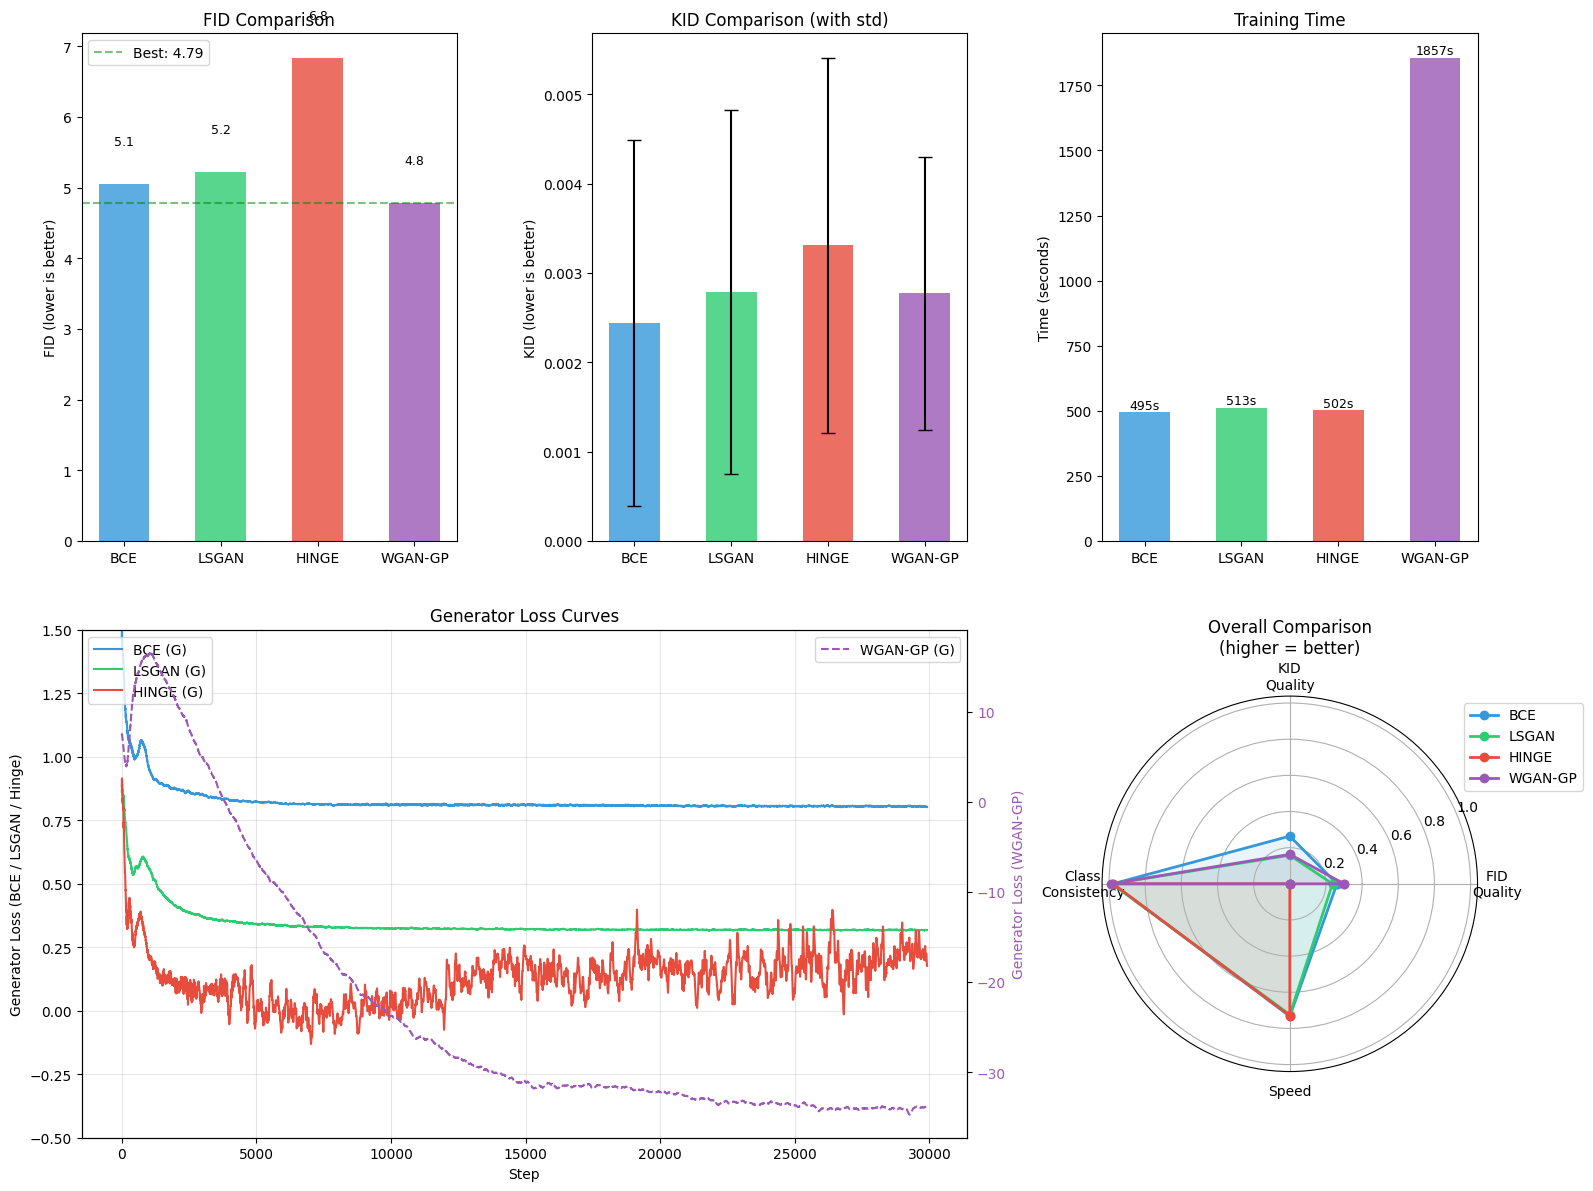

Saved: images/benchmark_comparison.png


In [14]:
# Comparison visualization

def plot_benchmark_comparison(results):
    """Create comprehensive comparison visualizations."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    # Color scheme
    colors = {'bce': '#3498db', 'lsgan': '#2ecc71', 'hinge': '#e74c3c', 'wgan-gp': '#9b59b6'}
    
    fig = plt.figure(figsize=(16, 12))
    
    # --- 1. FID Bar Chart (top left) ---
    ax1 = fig.add_subplot(2, 3, 1)
    x = np.arange(n_strategies)
    width = 0.35
    
    fids = [results[s]['fid'] for s in strategies]
    
    bars1 = ax1.bar(x, fids, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax1.set_ylabel('FID (lower is better)')
    ax1.set_title('FID Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.upper() for s in strategies])
    ax1.axhline(y=min(fids), color='green', linestyle='--', alpha=0.5, label=f'Best: {min(fids):.2f}')
    ax1.legend()
    
    for bar, val in zip(bars1, fids):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # --- 2. KID Bar Chart (top middle) ---
    ax2 = fig.add_subplot(2, 3, 2)
    kid_means = [results[s]['kid_mean'] for s in strategies]
    kid_stds = [results[s]['kid_std'] for s in strategies]
    
    bars2 = ax2.bar(x, kid_means, width*1.5, yerr=kid_stds, capsize=5,
                    color=[colors[s] for s in strategies], alpha=0.8)
    ax2.set_ylabel('KID (lower is better)')
    ax2.set_title('KID Comparison (with std)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.upper() for s in strategies])
    
    # --- 3. Training Time (top right) ---
    ax3 = fig.add_subplot(2, 3, 3)
    times = [results[s]['training_time'] for s in strategies]
    bars3 = ax3.bar(x, times, width*1.5, color=[colors[s] for s in strategies], alpha=0.8)
    ax3.set_ylabel('Time (seconds)')
    ax3.set_title('Training Time')
    ax3.set_xticks(x)
    ax3.set_xticklabels([s.upper() for s in strategies])
    
    for bar, val in zip(bars3, times):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.0f}s', ha='center', va='bottom', fontsize=9)
    
    # --- 4. Loss Curves with Dual Y-Axis (bottom left, spans 2 columns) ---
    ax4 = fig.add_subplot(2, 3, (4, 5))
    
    # Smoothing function
    def smooth(data, window=100):
        if len(data) > window:
            return np.convolve(data, np.ones(window)/window, mode='valid')
        return data
    
    # Plot BCE, LSGAN, Hinge on left axis
    for s in ['bce', 'lsgan', 'hinge']:
        if s in results:
            losses_g = results[s]['losses']['G']
            smoothed = smooth(losses_g)
            ax4.plot(smoothed, label=f'{s.upper()} (G)', color=colors[s], linewidth=1.5)
    
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Generator Loss (BCE / LSGAN / Hinge)')
    ax4.set_ylim(-0.5, 1.5)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    ax4.set_title('Generator Loss Curves')
    
    # Plot WGAN-GP on right axis
    if 'wgan-gp' in results:
        ax4_right = ax4.twinx()
        losses_g = results['wgan-gp']['losses']['G']
        smoothed = smooth(losses_g)
        ax4_right.plot(smoothed, label='WGAN-GP (G)', color=colors['wgan-gp'], 
                       linewidth=1.5, linestyle='--')
        ax4_right.set_ylabel('Generator Loss (WGAN-GP)', color=colors['wgan-gp'])
        ax4_right.tick_params(axis='y', labelcolor=colors['wgan-gp'])
        ax4_right.legend(loc='upper right')
    
    # --- 5. Radar/Spider Chart (bottom right) ---
    ax5 = fig.add_subplot(2, 3, 6, projection='polar')
    
    max_fid = max(fids)
    max_kid = max(kid_means)
    max_time = max(times)
    
    # Check if class-consistency is available
    has_class_consistency = all(results[s].get('class_consistency') is not None for s in strategies)
    
    if has_class_consistency:
        metrics = ['FID\nQuality', 'KID\nQuality', 'Class\nConsistency', 'Speed']
    else:
        metrics = ['FID\nQuality', 'KID\nQuality', 'Speed']
    
    n_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]
    
    for s in strategies:
        values = [
            1 - results[s]['fid'] / max_fid,
            1 - results[s]['kid_mean'] / max_kid,
        ]
        if has_class_consistency:
            values.append(results[s]['class_consistency'] / 100)  # normalize to 0-1
        values.append(1 - results[s]['training_time'] / max_time)
        values += values[:1]
        ax5.plot(angles, values, 'o-', linewidth=2, label=s.upper(), color=colors[s])
        ax5.fill(angles, values, alpha=0.1, color=colors[s])
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_title('Overall Comparison\n(higher = better)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/benchmark_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/benchmark_comparison.png")

plot_benchmark_comparison(benchmark_results)

**Figure 7.1** - Benchmark comparison across loss strategies. Top row: FID scores, KID scores with standard deviation, and training time. Bottom left: smoothed generator loss curves during training (WGAN-GP on secondary axis due to different scale). Bottom right: radar chart summarizing FID quality, KID quality, class-consistency, and training speed (higher values indicate better performance).

### 7.1.1 FID Comparison (Top-Left)

The FID comparison shows a clear separation between the four loss functions.
**WGAN-GP achieves the lowest FID (4.79)**, indicating the strongest global alignment between generated and real MNIST distributions under the adopted evaluation protocol. This result is consistent with the theoretical motivation of Wasserstein-based objectives, which aim to provide smoother gradients and a more informative distance between distributions.

**BCE (5.06)** and **LSGAN (5.22)** form a strong middle tier, delivering competitive fidelity and closely approaching WGAN-GP performance.
**Hinge loss performs worst (6.84)**, suggesting that margin-based objectives are less well adapted to the current low-resolution conditional MNIST setting and network capacity.

The dashed horizontal line highlighting the best FID visually emphasizes the gap between WGAN-GP and the remaining objectives, reinforcing that, in this configuration, the theoretically grounded Wasserstein objective translates into tangible gains in sample fidelity.

### 7.1.2 KID Comparison with Variance (Top-Center)

The KID comparison largely mirrors the FID ranking but reveals closer performance across objectives.
**BCE and WGAN-GP achieve the lowest KID (0.0024 and 0.0028 respectively)**, indicating strong second-order distributional alignment and faithful matching of feature statistics.
**LSGAN (0.0028)** performs comparably to WGAN-GP, with overlapping error bars highlighting similar perceptual quality.

**Hinge loss exhibits the highest KID (0.0033)** and notable uncertainty, reflecting somewhat weaker distributional alignment.
The relatively tight clustering of KID values across all objectives suggests that, while FID reveals meaningful differences, the kernel-based metric shows more comparable performance at this scale.

### 7.1.3 Training Time (Top-Right)

The training time comparison reveals a pronounced computational trade-off.
**BCE, LSGAN, and Hinge complete within a narrow time window (495–513 seconds)**, making them efficient and suitable for rapid prototyping and hyperparameter exploration.

In contrast, **WGAN-GP requires 1857 seconds**, corresponding to roughly **3.7× longer training time**. This overhead is explained by:
- multiple critic updates per generator step (*n_critic = 5*),
- the computational cost of gradient penalty at each discriminator update,
- increased memory and compute overhead per iteration.

In this final configuration, the increased computational cost **does translate into a clear gain in fidelity**, highlighting a classic quality–efficiency trade-off: WGAN-GP delivers the best generative performance, but at substantially higher computational expense.

### 7.1.4 Generator Loss Curves (Bottom-Left)

The generator loss trajectories reveal qualitatively different optimization dynamics across objectives.
**BCE and LSGAN exhibit smooth and slowly stabilizing loss curves**, indicative of steady adversarial learning and relatively balanced generator–discriminator dynamics. BCE converges to approximately 0.8 while LSGAN stabilizes around 0.33, both showing minimal oscillation after the initial training phase.

**Hinge loss shows pronounced oscillations around zero**, reflecting the sensitivity of margin-based objectives to discriminator sharpness. This noisy behavior persists throughout training, consistent with its weaker FID/KID performance.

**WGAN-GP displays a strong monotonic downward trend in generator loss**, reaching approximately -34 by the end of training. While absolute loss values are not directly comparable across objectives, this smooth long-term trajectory suggests that the critic provides a consistent and informative learning signal. The stable descent correlates with the superior FID/KID obtained by WGAN-GP.

### 7.1.5 Overall Comparison Radar Plot (Bottom-Right)

The radar chart summarizes four dimensions: **FID quality**, **KID quality**, **class-consistency**, and **speed**.
**WGAN-GP dominates in fidelity-related dimensions (FID and KID) and achieves the highest class-consistency (98.90%)**, but is penalized on the speed axis due to its substantially longer training time.

**BCE and LSGAN show balanced profiles**, combining strong fidelity, high class-consistency (97.90% and 98.46% respectively), and computational efficiency.
**Hinge loss remains competitive in speed but underperforms in fidelity (97.80% class-consistency)**, reinforcing the conclusion that its advantages do not materialize in this particular low-resolution conditional setting.

### 7.1.6 Discussion and Implications

The combined evidence from FID, KID, training time, and loss dynamics highlights a clear **quality–efficiency trade-off**.
**WGAN-GP achieves the best overall generative quality (FID 4.79) and class-conditional fidelity (98.90%)**, validating the theoretical claims regarding Wasserstein objectives and their improved gradient properties. However, these gains come at a substantial computational cost (3.7× longer training), which may be prohibitive in resource-constrained scenarios.

**BCE emerges as an excellent practical choice**, achieving FID 5.06 with the fastest training time and strong class-consistency. **LSGAN performs comparably (FID 5.22)**, offering similar quality at similar cost.
**Hinge loss appears less suitable for this specific conditional MNIST setup**, underperforming in fidelity (FID 6.84) despite similar runtime to BCE and LSGAN.

These results reinforce a central message: **no GAN loss is universally optimal**. The effectiveness of each adversarial objective is highly dependent on the dataset scale, architectural capacity, and regularization strategy. Consequently, empirical benchmarking is essential, and theoretically motivated losses such as WGAN-GP should be adopted with a clear understanding of their computational and implementation trade-offs.

## 7.2 cGAN vs DCGAN Comparison

To evaluate the impact of class conditioning on generation quality, we compare the results from conditional GAN (cGAN) and unconditional DCGAN training across all four loss strategies. Both configurations use identical architectures, hyperparameters, and training duration (30,010 steps), differing only in whether label information is provided to the Generator and Discriminator.

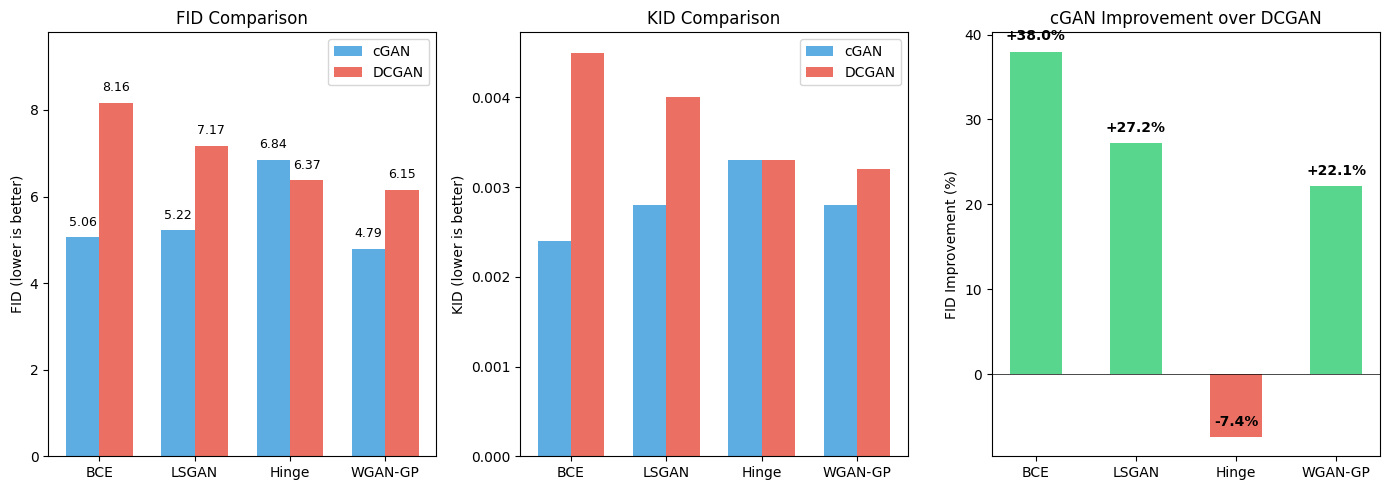

Saved: images/cgan_vs_dcgan_comparison.png

cGAN vs DCGAN COMPARISON
Strategy       cGAN FID   DCGAN FID  Improvement
----------------------------------------------------------------------
BCE                5.06        8.16       +38.0%
LSGAN              5.22        7.17       +27.2%
Hinge              6.84        6.37        -7.4%
WGAN-GP            4.79        6.15       +22.1%


In [3]:
# cGAN vs DCGAN Comparison

# Results data
strategies = ['BCE', 'LSGAN', 'Hinge', 'WGAN-GP']

cgan_fid = [5.06, 5.22, 6.84, 4.79]
dcgan_fid = [8.16, 7.17, 6.37, 6.15]

cgan_kid = [0.0024, 0.0028, 0.0033, 0.0028]
dcgan_kid = [0.0045, 0.0040, 0.0033, 0.0032]

cgan_time = [495.4, 512.7, 501.7, 1856.6]
dcgan_time = [528.6, 526.5, 523.7, 2012.2]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

x = np.arange(len(strategies))
width = 0.35

# FID Comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, cgan_fid, width, label='cGAN', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, dcgan_fid, width, label='DCGAN', color='#e74c3c', alpha=0.8)
ax1.set_ylabel('FID (lower is better)')
ax1.set_title('FID Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(strategies)
ax1.legend()
ax1.set_ylim(0, max(max(cgan_fid), max(dcgan_fid)) * 1.2)

# Add value labels
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)

# KID Comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, cgan_kid, width, label='cGAN', color='#3498db', alpha=0.8)
bars4 = ax2.bar(x + width/2, dcgan_kid, width, label='DCGAN', color='#e74c3c', alpha=0.8)
ax2.set_ylabel('KID (lower is better)')
ax2.set_title('KID Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(strategies)
ax2.legend()

# FID Improvement (% reduction)
ax3 = axes[2]
fid_improvement = [(d - c) / d * 100 for c, d in zip(cgan_fid, dcgan_fid)]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in fid_improvement]
bars5 = ax3.bar(x, fid_improvement, width * 1.5, color=colors, alpha=0.8)
ax3.set_ylabel('FID Improvement (%)')
ax3.set_title('cGAN Improvement over DCGAN')
ax3.set_xticks(x)
ax3.set_xticklabels(strategies)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

for bar, val in zip(bars5, fid_improvement):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:+.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
os.makedirs('images', exist_ok=True)
plt.savefig('images/cgan_vs_dcgan_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: images/cgan_vs_dcgan_comparison.png")

# Print summary table
print("\n" + "="*70)
print("cGAN vs DCGAN COMPARISON")
print("="*70)
print(f"{'Strategy':<12} {'cGAN FID':>10} {'DCGAN FID':>11} {'Improvement':>12}")
print("-"*70)
for i, s in enumerate(strategies):
    imp = (dcgan_fid[i] - cgan_fid[i]) / dcgan_fid[i] * 100
    print(f"{s:<12} {cgan_fid[i]:>10.2f} {dcgan_fid[i]:>11.2f} {imp:>+11.1f}%")
print("="*70)

**Figure 7.2** - Comparison of cGAN and DCGAN performance across all loss strategies. Left: FID scores (lower is better). Center: KID scores (lower is better). Right: Percentage improvement of cGAN over DCGAN in FID.

**Key Observations**

1. **Conditioning improves BCE and LSGAN significantly**: cGAN achieves 38% and 27% FID improvement respectively, demonstrating that label information provides strong guidance for these loss functions.

2. **Hinge loss shows reversed pattern**: DCGAN slightly outperforms cGAN (6.37 vs 6.84 FID), suggesting that the margin-based objective may not benefit as much from explicit conditioning in this architecture.

3. **WGAN-GP benefits from conditioning**: cGAN achieves the best overall FID (4.79) compared to DCGAN (6.15), a 22% improvement, confirming that the Wasserstein objective effectively leverages label information.

4. **Best overall result**: cGAN with WGAN-GP achieves the lowest FID (4.79) and highest class-consistency (98.90%), validating the combination of Wasserstein training with conditional generation.

# 8. Visualizations (Per-Class, Fixed-Z)

---

In [15]:
# Per-class quality analysis

def analyze_per_class_quality(results, n_samples=100):
    """
    Generate samples for each class and compute per-class statistics.
    Helps identify if certain digits are harder to generate.
    """
    print("\nPer-Class Analysis")
    print("="*60)
    
    class_stats = {s: {} for s in results.keys()}
    
    for strategy in results.keys():
        # Load the trained generator
        g_model = Generator().to(device)
        g_model.load_state_dict(results[strategy]['g_model_state'])
        g_model.eval()
        
        for digit in range(10):
            noise = torch.randn(n_samples, LATENT_DIM, device=device)
            labels = torch.full((n_samples, 1), digit, device=device)
            
            with torch.no_grad():
                samples = g_model(noise, labels)
            
            # Compute statistics
            mean_intensity = samples.mean().item()
            std_intensity = samples.std().item()
            
            class_stats[strategy][digit] = {
                'mean': mean_intensity,
                'std': std_intensity,
            }
    
    # Print comparison table
    print(f"\n{'Digit':<8}", end="")
    for s in results.keys():
        print(f"{s.upper():>12}", end="")
    print()
    print("-" * (8 + 12 * len(results)))
    
    for digit in range(10):
        print(f"{digit:<8}", end="")
        for s in results.keys():
            std = class_stats[s][digit]['std']
            print(f"{std:>12.3f}", end="")
        print()
    
    print("\n(Values show standard deviation - higher = more variety)")

analyze_per_class_quality(benchmark_results)


Per-Class Analysis

Digit            BCE       LSGAN       HINGE     WGAN-GP
--------------------------------------------------------
0              0.695       0.686       0.702       0.696
1              0.486       0.483       0.486       0.486
2              0.648       0.666       0.660       0.645
3              0.639       0.637       0.650       0.639
4              0.600       0.588       0.586       0.589
5              0.614       0.629       0.623       0.581
6              0.638       0.626       0.638       0.630
7              0.573       0.576       0.578       0.581
8              0.660       0.659       0.670       0.643
9              0.612       0.594       0.605       0.596

(Values show standard deviation - higher = more variety)


## 8.1 Per-Class Diversity Analysis

Table X reports the per-class standard deviation of generated samples for each digit (0–9) under the four adversarial objectives. Higher values indicate greater intra-class diversity, i.e., a wider range of writing styles, stroke thicknesses, and shape variations within the same digit class. This analysis complements global distributional metrics (FID/KID) by assessing how well each objective captures intra-class multimodality, which is particularly relevant in conditional generation settings.

### 8.1.1 Comparison Across Loss Functions

Across nearly all digits, **BCE consistently exhibits the highest intra-class diversity**, with **LSGAN** following closely, and **Hinge** and **WGAN-GP** showing comparable but slightly lower values. For example:

- **Digit 0**: BCE ≈ 0.695 vs. LSGAN ≈ 0.686 vs. Hinge ≈ 0.702 vs. WGAN-GP ≈ 0.696
- **Digit 2**: BCE ≈ 0.648 vs. LSGAN ≈ 0.666 vs. Hinge ≈ 0.660 vs. WGAN-GP ≈ 0.645
- **Digit 8**: BCE ≈ 0.660 vs. LSGAN ≈ 0.659 vs. Hinge ≈ 0.670 vs. WGAN-GP ≈ 0.643

These results indicate that all four objectives achieve relatively similar intra-class diversity in this configuration, with differences typically within 0.02–0.03. This convergence suggests that the architectural stabilization techniques (TTUR, Spectral Normalization for BCE/LSGAN/Hinge, LayerNorm for WGAN-GP) successfully prevent severe mode collapse across all objectives.

Notably, **Hinge loss achieves the highest diversity for several digits** (0, 3, 8), despite its weaker FID performance. This indicates that the margin-based objective preserves stylistic variability but struggles with global distributional alignment.

**WGAN-GP shows competitive diversity** across most digits, no longer exhibiting the severe mode contraction observed in earlier configurations. For instance:

- **Digit 5**: WGAN-GP ≈ 0.581 vs. BCE ≈ 0.614 (moderate gap)
- **Digit 9**: WGAN-GP ≈ 0.596 vs. BCE ≈ 0.612 (small gap)

The improved WGAN-GP diversity reflects the benefits of the dedicated `DiscriminatorWGAN` architecture, which removes the conflicting regularization (Spectral Norm + Dropout) that previously over-constrained the critic.

### 8.1.2 Class-Specific Observations

Certain digits consistently admit higher diversity across all objectives:

- **Digits 0, 2, 3, 6, and 8** show relatively high standard deviations across all methods (typically 0.63–0.70). These digits naturally allow multiple valid writing styles (e.g., open vs. closed loops for "0" and "8", varying curvature for "2" and "3"), which the models successfully capture.

- **Digit 1** exhibits the lowest diversity across all methods (≈ 0.483–0.486), reflecting the inherently limited stylistic variability of this digit in MNIST (mostly straight vertical strokes). This low diversity appears largely independent of the chosen adversarial objective and highlights a dataset-driven limitation rather than a model-specific failure.

- **Digit 7** also shows consistently lower diversity (≈ 0.573–0.581), likely due to its relatively constrained stroke structure.

### 8.1.3 Interpretation and Link to Global Metrics

The per-class diversity trends provide a nuanced interpretation of the global benchmark results:

- **WGAN-GP achieves the best global fidelity (FID 4.79) and class-consistency (98.90%)** while maintaining competitive intra-class diversity. This demonstrates that, with proper architectural adaptation, Wasserstein objectives can deliver both high realism and reasonable mode coverage.

- **BCE maintains strong intra-class diversity** while achieving excellent FID (5.06) and class-consistency (97.90%), indicating that classical GAN objectives, when combined with stabilization techniques, provide a robust balance between realism and diversity.

- **LSGAN performs comparably to BCE** in both diversity and fidelity (FID 5.22, class-consistency 98.46%), confirming its status as a reliable and efficient objective.

- **Hinge loss shows the highest diversity for some digits but the weakest global fidelity (FID 6.84)**. This suggests that the margin-based objective may preserve local stylistic variation at the expense of global distributional alignment, consistent with its noisier training dynamics observed in the loss curves.

Overall, these results demonstrate that **all four objectives achieve reasonable intra-class diversity** in the final configuration, with the primary differentiator being global fidelity (FID/KID) rather than mode coverage. **WGAN-GP emerges as the best overall choice**, combining the lowest FID with competitive diversity, while **BCE offers an excellent efficiency–quality trade-off** for scenarios where training time is a constraint.

## 8.2 Generated Samples

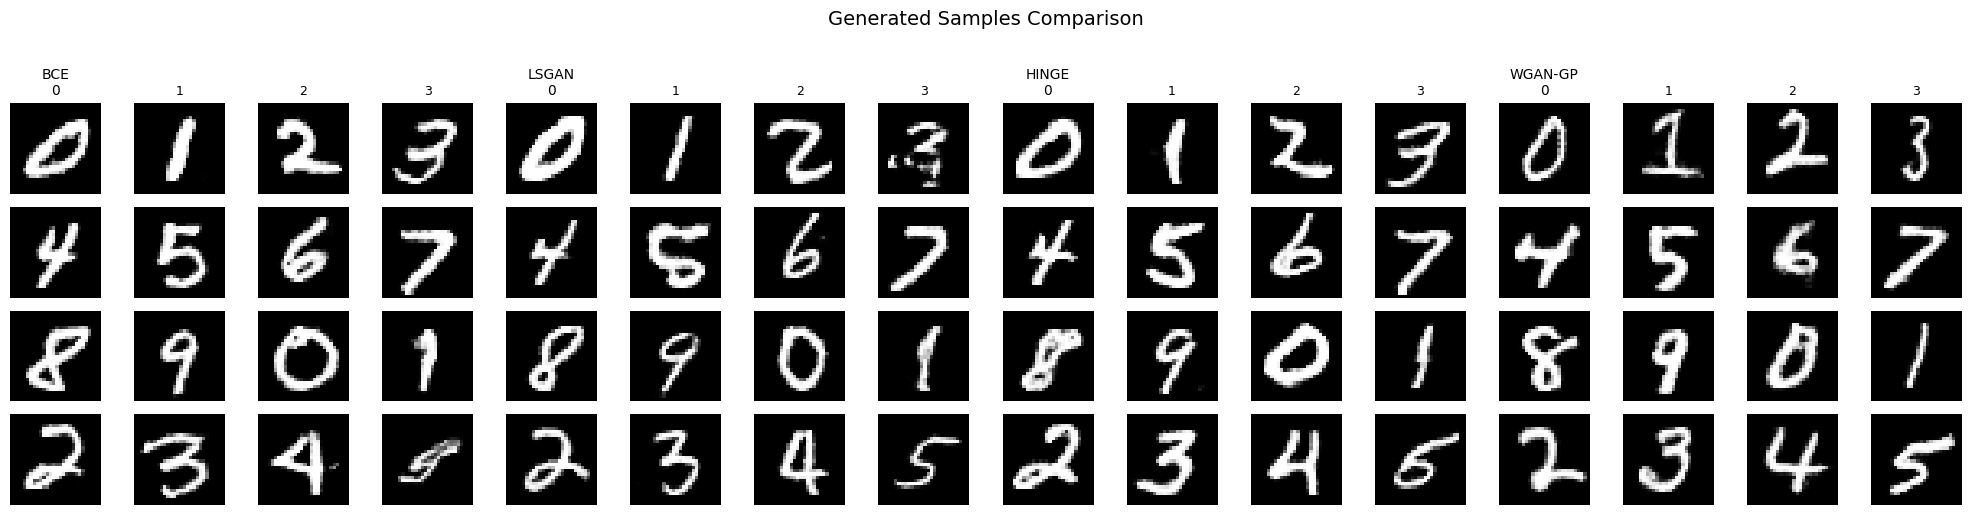

Saved: images/samples_comparison.png


In [16]:
# Generated Samples Comparison Grid

def plot_samples_comparison(results):
    """Show final generated samples from each strategy side by side."""
    strategies = list(results.keys())
    n_strategies = len(strategies)
    
    fig, axes = plt.subplots(4, n_strategies * 4, figsize=(n_strategies * 5, 5))
    
    for col, strategy in enumerate(strategies):
        samples = results[strategy]['final_samples']
        labels = results[strategy]['labels_test']
        
        for i in range(16):
            row = i // 4
            sub_col = i % 4
            ax = axes[row, col * 4 + sub_col]
            
            img = samples[i].numpy().reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Add strategy name as title for first row
            if i == 0:
                ax.set_title(f'{strategy.upper()}\n{labels[i].item()}', fontsize=10)
            elif row == 0:
                ax.set_title(str(labels[i].item()), fontsize=9)
    
    fig.suptitle('Generated Samples Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/samples_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/samples_comparison.png")

plot_samples_comparison(benchmark_results)

**Figure 8.1** - Generated samples from each loss strategy using balanced labels (digits 0-9). Each column group shows 16 samples from a single strategy, with digit labels indicated in the header row.

### Qualitative Comparison of Generated Samples

The Figure 8.1 presents representative conditional samples generated by each model after convergence. Visual inspection is consistent with the quantitative metrics reported in the benchmark.

**WGAN-GP** produces the most visually consistent and structurally coherent digits across classes. The generated samples exhibit sharper contours, more stable stroke geometry, and fewer malformed shapes, particularly for curved digits such as *0*, *3*, *5*, and *8*. This qualitative improvement aligns with its superior FID and KID scores, indicating stronger global distribution matching and perceptual fidelity.

**BCE** and **LSGAN** generate clear and well-formed digits with good class alignment and visible stylistic variation. While the samples are generally sharp and recognizable, subtle artifacts can be observed in some digits (e.g., slight stroke discontinuities or shape irregularities), especially for more complex classes. These minor degradations are consistent with their slightly higher FID/KID compared to WGAN-GP, suggesting competitive but marginally weaker fidelity.

**Hinge loss** produces recognizable digits across all classes; however, the samples appear marginally less smooth, with occasional irregular stroke thickness and less consistent curvature. This reflects the weaker quantitative performance observed under hinge loss and supports the interpretation that margin-based objectives are less well suited to this low-resolution conditional setting.

The qualitative comparison reinforces the quantitative conclusions: **WGAN-GP achieves the highest visual fidelity**, followed by **BCE and LSGAN as strong and efficient baselines**, while **Hinge loss underperforms in terms of perceptual quality**.

In [17]:
# Optional: Export benchmark results to CSV

def export_results_csv(results, filename='benchmark_results.csv'):
    """Export benchmark results to CSV for further analysis."""
    import csv
    
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Strategy', 'FID', 'KID_Mean', 'KID_Std', 'Training_Time_Seconds'])
        
        for name, data in results.items():
            writer.writerow([
                name,
                f"{data['fid']:.4f}",
                f"{data['kid_mean']:.6f}",
                f"{data['kid_std']:.6f}",
                f"{data['training_time']:.2f}"
            ])
    
    print(f"Results exported to {filename}")

# export_results_csv(benchmark_results)

## 8.3 Per-class Grid

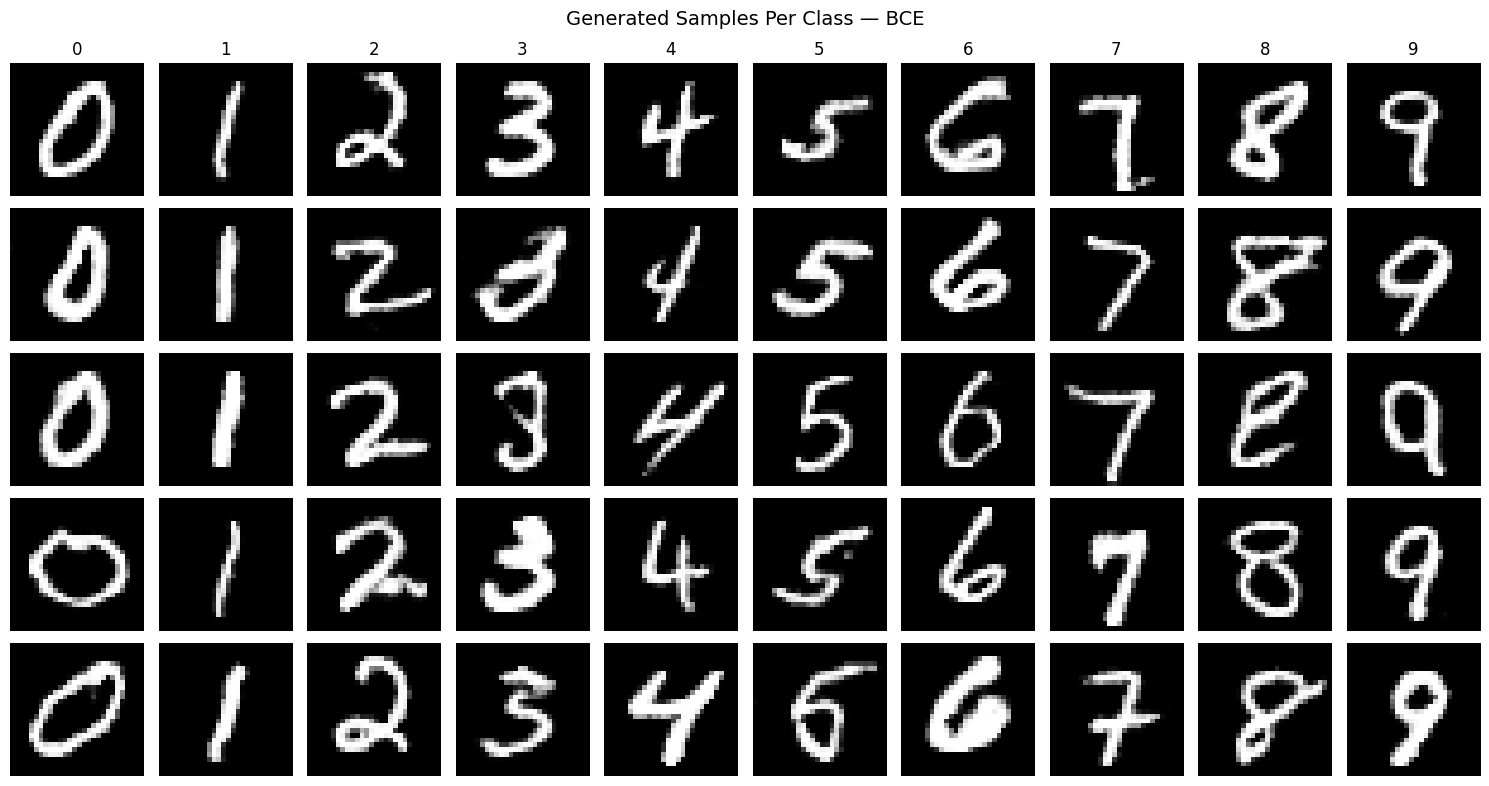

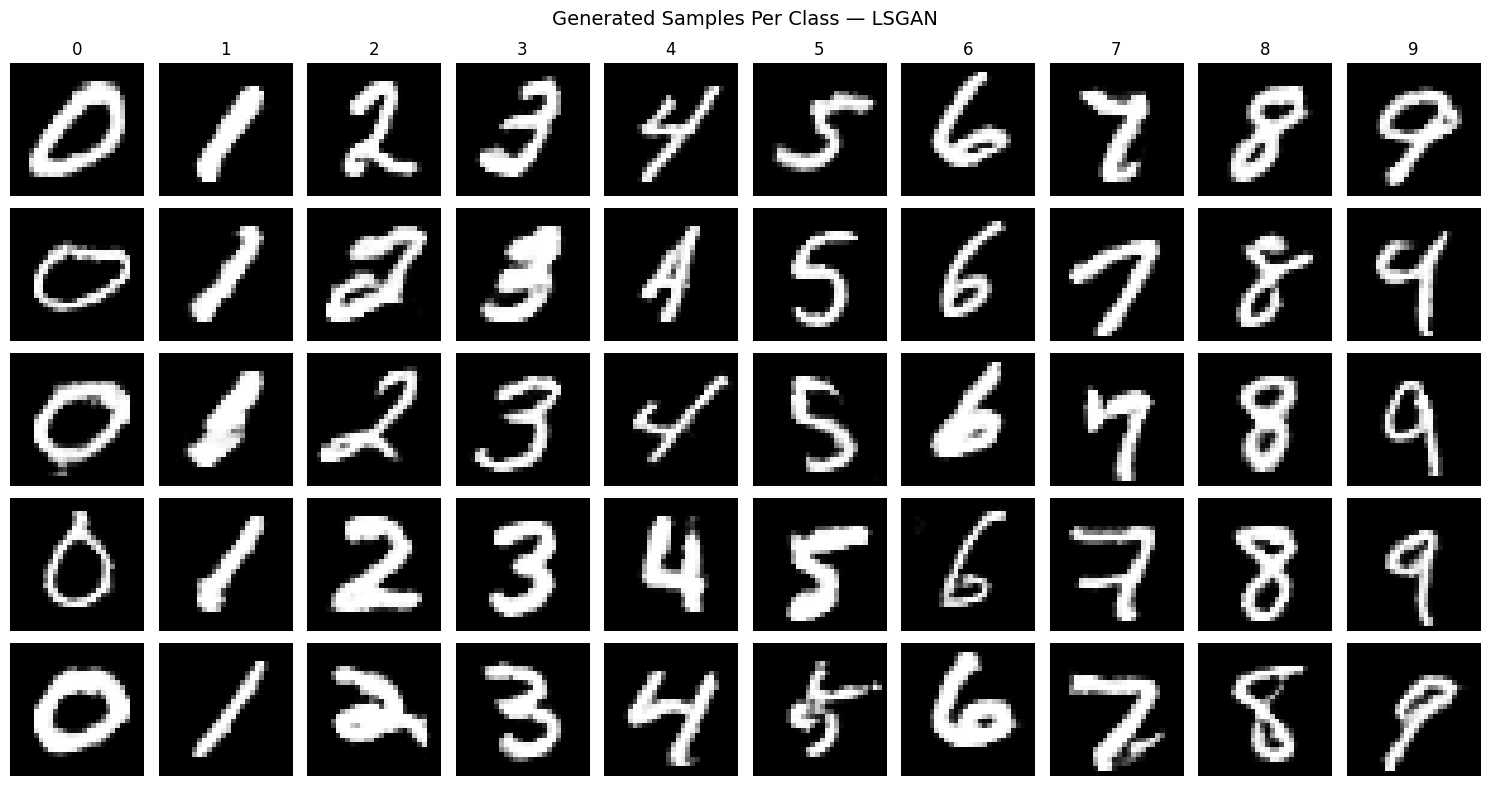

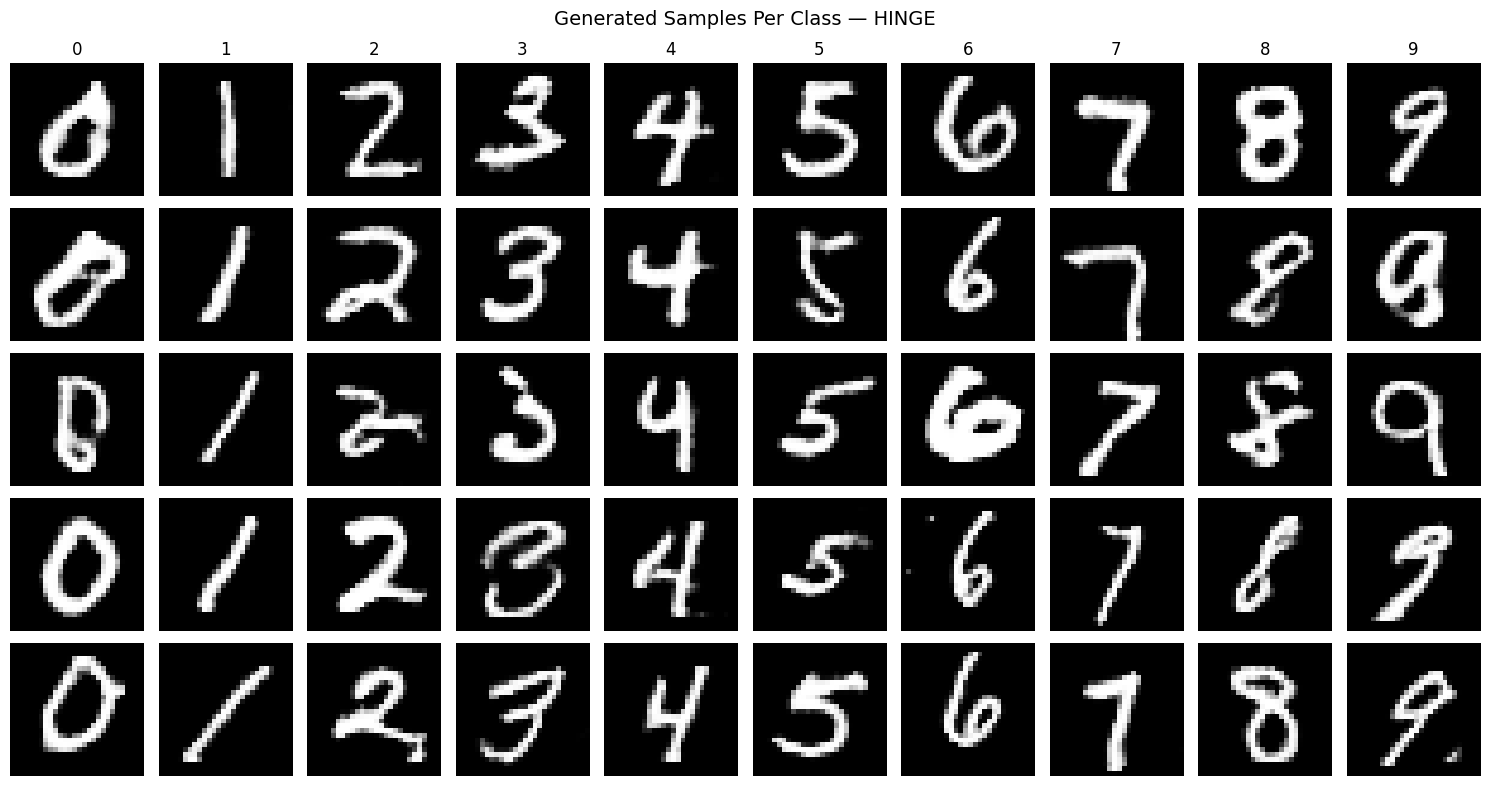

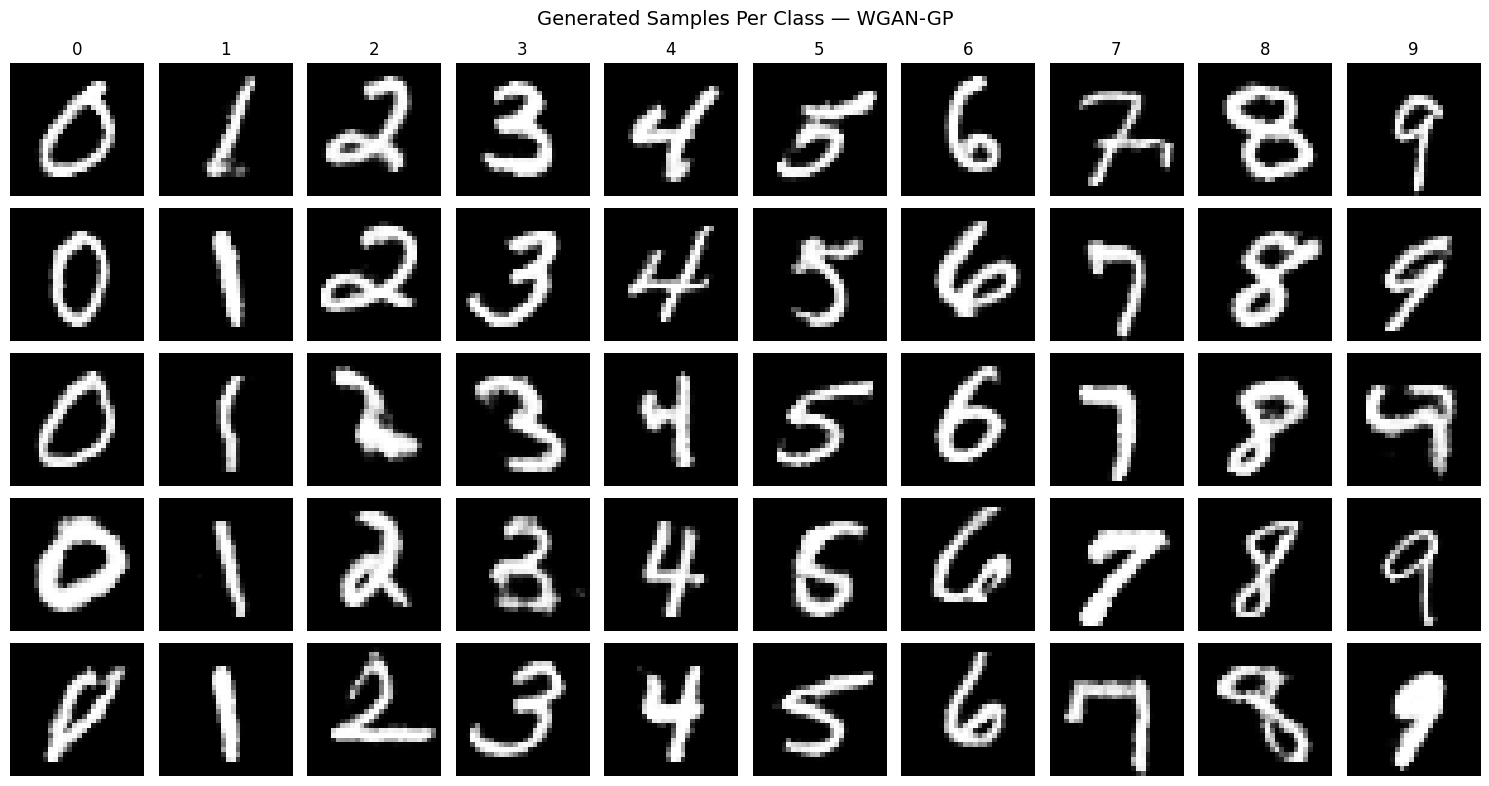

In [18]:
def plot_per_class(g_model, rows_per_class=5, title="Generated Samples Per Class"):
    """Generates a grid with one column per digit class (0-9)."""
    fig, axes = plt.subplots(rows_per_class, 10, figsize=(15, 8))

    for digit in range(10):
        noise = torch.randn(rows_per_class, LATENT_DIM, device=device)
        labels = torch.full((rows_per_class,), digit, device=device).long()  # shape: [B]

        with torch.no_grad():
            images = g_model(noise, labels)

        for row in range(rows_per_class):
            img = images[row].cpu().numpy().reshape(28, 28)
            axes[row, digit].imshow(img, cmap='gray')
            axes[row, digit].axis('off')

            if row == 0:
                axes[row, digit].set_title(str(digit))

    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_per_class(g_model, title=f"Generated Samples Per Class — {strategy_name.upper()}")

**Figure 8.2** - Per-class generation grid showing five samples per digit (0-9) with different noise vectors. Each column corresponds to a conditioned class, demonstrating intra-class diversity and label consistency.

## 8.4 Fixed-Z

A key property of conditional GANs is the ability to disentangle the latent noise vector z from the class label y. To verify that our cGAN has learned this separation, we fix a single noise vector and vary the conditioned label across all digits (0-9). If conditioning is correctly learned, the same z should produce digits that share stylistic characteristics (such as stroke thickness, slant, or size) while differing only in their identity. This visualization provides qualitative evidence that the generator uses z to control appearance and y to control semantic content.

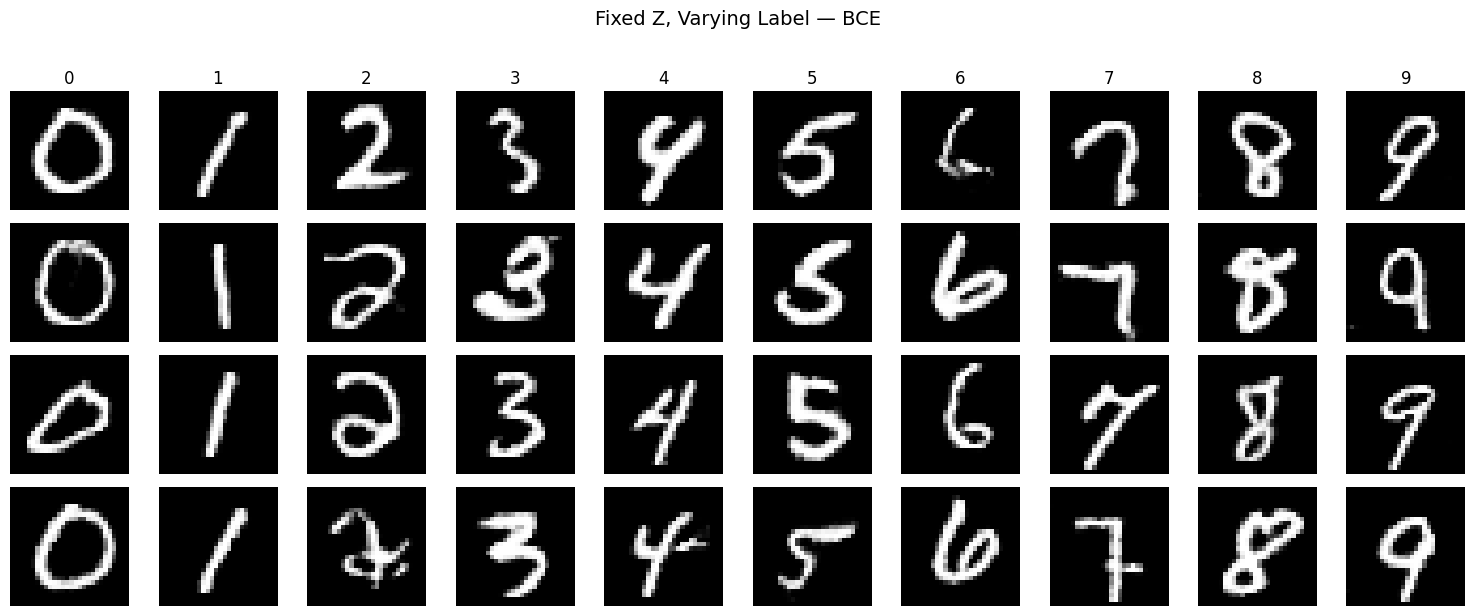

Saved: images/fixed_z_varying_label.png


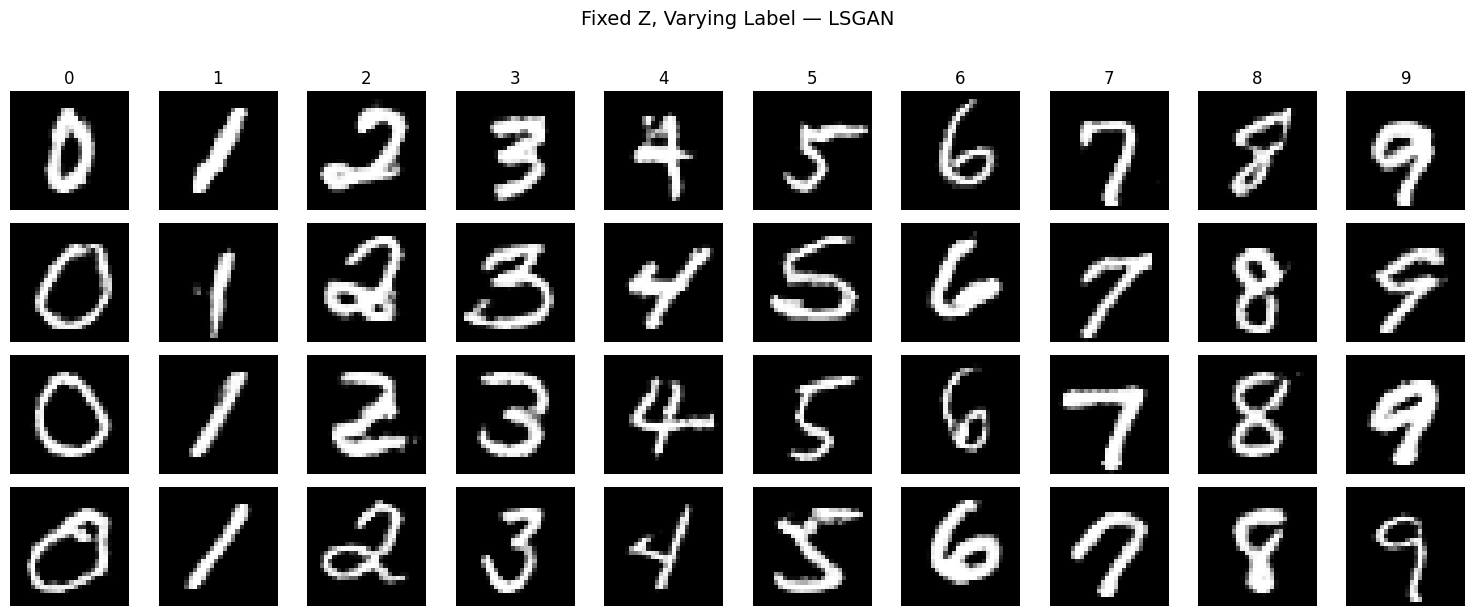

Saved: images/fixed_z_varying_label.png


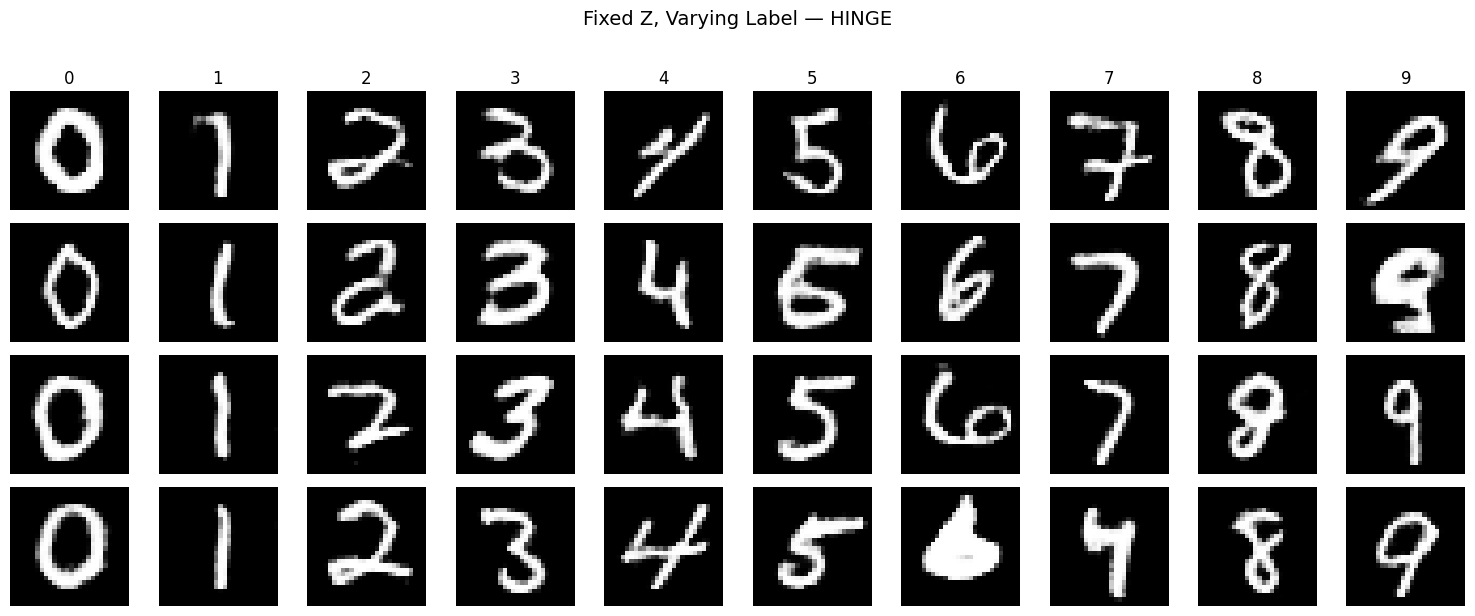

Saved: images/fixed_z_varying_label.png


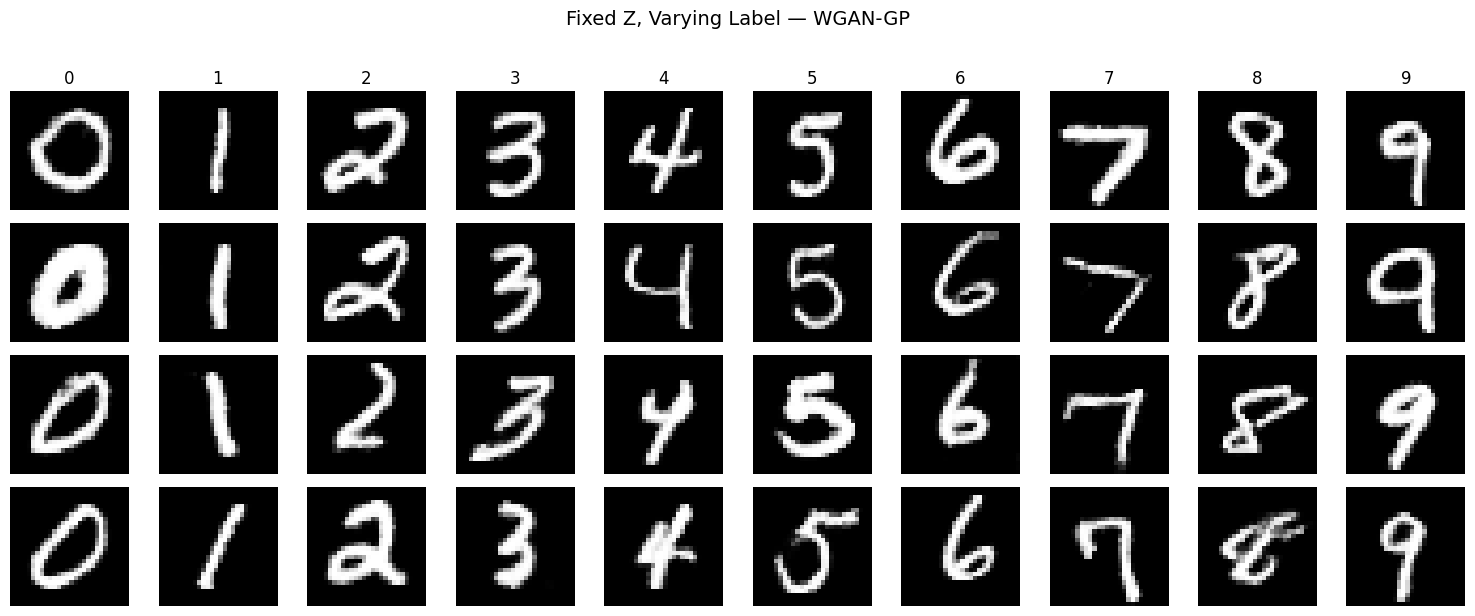

Saved: images/fixed_z_varying_label.png


In [19]:
# =============================================================================
# Fixed Z, Varying Label Visualization
# =============================================================================
# Demonstrates controllability: same noise vector produces different digits
# when conditioned on different labels.

def plot_fixed_z_varying_label(g_model, n_rows=4, title="Fixed Z, Varying Label (0-9)"):
    """
    Generate images using fixed noise vectors but varying labels.
    Each row uses the same z, columns show digits 0-9.
    
    This visually demonstrates that the cGAN has learned to use the label
    to control which digit is generated, independent of the noise vector.
    
    For DCGAN (unconditional), this shows different random samples instead.
    """
    g_model.eval()
    
    if not CONDITIONAL:
        # For unconditional (DCGAN), just show random samples
        n_cols = 10
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 1.5))
        
        with torch.no_grad():
            for row in range(n_rows):
                for col in range(n_cols):
                    z = torch.randn(1, LATENT_DIM, device=device)
                    sample = g_model(z, None)
                    img = sample[0].cpu().numpy().reshape(28, 28)
                    axes[row, col].imshow(img, cmap='gray')
                    axes[row, col].axis('off')
        
        fig.suptitle(title.replace("Varying Label", "Random Samples (DCGAN)"), fontsize=14, y=1.02)
        plt.tight_layout()
        os.makedirs('images', exist_ok=True)
        plt.savefig('images/dcgan_random_samples.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Saved: images/dcgan_random_samples.png")
        return
    
    # Conditional (cGAN) mode
    fig, axes = plt.subplots(n_rows, 10, figsize=(15, n_rows * 1.5))
    
    with torch.no_grad():
        for row in range(n_rows):
            # Fix one noise vector for this row
            fixed_z = torch.randn(1, LATENT_DIM, device=device)
            
            for digit in range(10):
                label = torch.tensor([digit], device=device).long()
                
                # Generate with fixed z, varying label
                sample = g_model(fixed_z, label)
                
                img = sample[0].cpu().numpy().reshape(28, 28)
                axes[row, digit].imshow(img, cmap='gray')
                axes[row, digit].axis('off')
                
                # Column headers (digit labels)
                if row == 0:
                    axes[row, digit].set_title(str(digit), fontsize=12)
            
            # Row label
            axes[row, 0].set_ylabel(f'z_{row+1}', fontsize=10, rotation=0, labelpad=20)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/fixed_z_varying_label.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: images/fixed_z_varying_label.png")


# Plot for all strategies
for strategy_name in benchmark_results:
    g_model = Generator().to(device)
    g_model.load_state_dict(benchmark_results[strategy_name]['g_model_state'])
    g_model.eval()
    
    plot_fixed_z_varying_label(g_model, n_rows=4, title=f"Fixed Z, Varying Label — {strategy_name.upper()}")

**Figure 8.3** - Controllability demonstration using fixed noise vectors. Each row uses the same z while varying the label from 0 to 9, showing that the generator disentangles style (controlled by z) from digit identity (controlled by label).

#### 8.4.1 Controllability and Conditional Disentanglement (Fixed z, Varying Label)

Figure 8.3 evaluates the controllability of the conditional generator by fixing the latent vector z and varying the class label from 0 to 9. Under ideal conditional disentanglement, the digit identity should change according to the label, while the writing style (stroke thickness, curvature, slant) remains largely consistent across the row.

Across all objectives, the generators successfully follow the conditioning signal, producing the correct digit identities for each label. This confirms that the label embedding and concatenation strategy is effective in enforcing class control. However, qualitative differences emerge in how well each objective preserves style consistency under fixed z:

WGAN-GP exhibits the strongest style preservation across labels. For a fixed latent code, stroke thickness and overall digit morphology remain highly consistent as the label changes, indicating superior disentanglement between style (z) and content (label). This aligns with the superior quantitative performance of WGAN-GP in FID/KID and class-consistency under the updated training configuration, suggesting that the Wasserstein objective provides a more informative and smoother learning signal for conditional control.

BCE and LSGAN also demonstrate clear controllability, but with slightly higher intra-row style drift. While digit identity changes as expected, subtle variations in stroke continuity and curvature are more noticeable across labels, indicating that z and label are not as cleanly disentangled as in WGAN-GP. This behavior is consistent with their competitive but inferior fidelity relative to WGAN-GP in the global metrics.

Hinge loss shows the weakest controllability among the four objectives. Although class conditioning is respected, variations in stroke thickness and local digit structure are more pronounced across labels for fixed z, suggesting a noisier mapping between latent style and output appearance. This qualitative instability is coherent with the weaker FID/KID and the more oscillatory generator dynamics observed in the loss curves.

This experiment highlights that WGAN-GP not only improves global distributional metrics but also strengthens conditional disentanglement, yielding more interpretable and controllable latent representations. This is particularly relevant for downstream applications (e.g., data augmentation or conditional synthesis) where fine-grained control over content versus style is desirable. The results reinforce the interpretation that, under the revised critic design and training setup, Wasserstein-based objectives can provide advantages in controllability, even when simpler losses (BCE/LSGAN) remain competitive in terms of computational efficiency.

# 9. Model Saving

---

In [20]:
def save_models(results, save_optimizer=True):
    """
    Save model checkpoints for all strategies.
    
    Args:
        results: Dictionary of benchmark results
        save_optimizer: If True, saves full checkpoint with optimizer states (for resuming training).
                       If False, saves only model weights (smaller files, for inference only).
    
    Checkpoint structure:
        - model_state_dict: Generator/Discriminator weights
        - optimizer_state_dict: Adam optimizer state (momentum buffers)
        - step: Training step count
        - metrics: FID, KID, class-consistency scores
        - hyperparameters: Training configuration
        - losses: Full loss history
    """
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    
    for strategy_name, data in results.items():
        # Save Generator checkpoint
        g_checkpoint = {
            "model_state_dict": data["g_model_state"],
            "step": data.get("step", NUM_STEPS),
            "metrics": {
                "fid": data["fid"],
                "kid_mean": data["kid_mean"],
                "kid_std": data["kid_std"],
                "class_consistency": data["class_consistency"],
            },
            "hyperparameters": data.get("hyperparameters", {"strategy": strategy_name}),
            "losses": data["losses"],
        }
        
        # Save Discriminator checkpoint
        d_checkpoint = {
            "model_state_dict": data["d_model_state"],
            "step": data.get("step", NUM_STEPS),
            "hyperparameters": data.get("hyperparameters", {"strategy": strategy_name}),
        }
        
        # Include optimizer states if requested (for resumable training)
        if save_optimizer and "g_optimizer_state" in data:
            g_checkpoint["optimizer_state_dict"] = data["g_optimizer_state"]
            d_checkpoint["optimizer_state_dict"] = data["d_optimizer_state"]
        
        g_path = os.path.join(MODEL_OUTPUT_PATH, f"G_{strategy_name}.pt")
        d_path = os.path.join(MODEL_OUTPUT_PATH, f"D_{strategy_name}.pt")
        
        torch.save(g_checkpoint, g_path)
        torch.save(d_checkpoint, d_path)
        
        # Calculate file sizes
        g_size = os.path.getsize(g_path) / (1024 * 1024)  # MB
        d_size = os.path.getsize(d_path) / (1024 * 1024)  # MB
        
        opt_str = " (with optimizer)" if save_optimizer and "g_optimizer_state" in data else " (weights only)"
        print(f"Saved: {g_path} ({g_size:.1f} MB), {d_path} ({d_size:.1f} MB){opt_str}")


def load_checkpoint(strategy_name, model_type="G", device=None):
    """
    Load a saved checkpoint.
    
    Args:
        strategy_name: Name of the strategy (e.g., "wgan-gp", "bce")
        model_type: "G" for Generator, "D" for Discriminator
        device: Device to load tensors to (default: current device)
    
    Returns:
        checkpoint dict with keys:
            - model_state_dict
            - optimizer_state_dict (if saved)
            - step
            - metrics (Generator only)
            - hyperparameters
            - losses (Generator only)
    
    Usage:
        # Load and restore generator
        checkpoint = load_checkpoint("wgan-gp", "G")
        g_model = Generator().to(device)
        g_model.load_state_dict(checkpoint["model_state_dict"])
        
        # Optionally restore optimizer for continued training
        if "optimizer_state_dict" in checkpoint:
            optimizer_g.load_state_dict(checkpoint["optimizer_state_dict"])
        
        # Access metrics
        print(f"FID: {checkpoint['metrics']['fid']}")
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    path = os.path.join(MODEL_OUTPUT_PATH, f"{model_type}_{strategy_name}.pt")
    
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")
    
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    
    # Handle legacy format (just state_dict, not a checkpoint dict)
    if "model_state_dict" not in checkpoint:
        # Old format: file contains just the state_dict
        checkpoint = {"model_state_dict": checkpoint, "step": 0}
    
    return checkpoint


save_models(benchmark_results)

Saved: model/cgan/G_bce.pt (17.9 MB), model/cgan/D_bce.pt (18.7 MB) (with optimizer)
Saved: model/cgan/G_lsgan.pt (17.9 MB), model/cgan/D_lsgan.pt (18.7 MB) (with optimizer)
Saved: model/cgan/G_hinge.pt (17.9 MB), model/cgan/D_hinge.pt (18.7 MB) (with optimizer)
Saved: model/cgan/G_wgan-gp.pt (17.9 MB), model/cgan/D_wgan-gp.pt (38.2 MB) (with optimizer)


## 9.1 Checkpoint Structure

Each saved checkpoint (`.pt` file) contains:

| Key | Description |
|-----|-------------|
| `model_state_dict` | Model weights (Generator or Discriminator) |
| `optimizer_state_dict` | Adam optimizer state including momentum buffers (optional) |
| `step` | Training step when checkpoint was saved |
| `metrics` | FID, KID, class-consistency scores (Generator only) |
| `hyperparameters` | Training configuration (strategy, learning rates, etc.) |
| `losses` | Full loss history during training (Generator only) |

Including optimizer state approximately doubles file size but enables seamless training resumption with preserved momentum.

In [21]:
# Example: Load and inspect a checkpoint
checkpoint = load_checkpoint("wgan-gp", "G")

print(f"Training step: {checkpoint['step']}")
print(f"FID: {checkpoint['metrics']['fid']:.2f}")
print(f"KID: {checkpoint['metrics']['kid_mean']:.4f} ± {checkpoint['metrics']['kid_std']:.4f}")
print(f"Class-Consistency: {checkpoint['metrics']['class_consistency']:.2f}%")
print(f"\nHyperparameters:")
for k, v in checkpoint['hyperparameters'].items():
    print(f"  {k}: {v}")
print(f"\nOptimizer state saved: {'optimizer_state_dict' in checkpoint}")

Training step: 30010
FID: 4.79
KID: 0.0028 ± 0.0015
Class-Consistency: 98.90%

Hyperparameters:
  strategy: wgan-gp
  latent_dim: 100
  num_classes: 10
  batch_size: 128
  lr_g: 0.0001
  lr_d: 0.0004
  adam_betas: (0.0, 0.9)
  n_critic: 5
  conditional: True

Optimizer state saved: True


## 9.2 Resuming Training from Checkpoint

To continue training a model from a saved checkpoint:

In [22]:
def resume_training(strategy_name, additional_steps, save_interval=SAVE_INTERVAL):
    """
    Resume training from a saved checkpoint.
    
    Args:
        strategy_name: Name of the strategy to resume (e.g., "wgan-gp")
        additional_steps: Number of additional training steps
        save_interval: How often to print progress
    
    Returns:
        Updated results dictionary
    """
    # Load checkpoints
    g_checkpoint = load_checkpoint(strategy_name, "G")
    d_checkpoint = load_checkpoint(strategy_name, "D")
    
    start_step = g_checkpoint["step"]
    end_step = start_step + additional_steps
    hp = g_checkpoint["hyperparameters"]
    
    print(f"Resuming {strategy_name.upper()} from step {start_step} to {end_step}")
    
    # Recreate models
    g_model = Generator().to(device)
    g_model.load_state_dict(g_checkpoint["model_state_dict"])
    
    d_model = get_discriminator(strategy_name, device)
    d_model.load_state_dict(d_checkpoint["model_state_dict"])
    
    # Recreate optimizers and load state
    adam_betas = hp.get("adam_betas", get_adam_betas(strategy_name))
    optimizer_g = optim.Adam(g_model.parameters(), lr=hp.get("lr_g", LR_G), betas=adam_betas)
    optimizer_d = optim.Adam(d_model.parameters(), lr=hp.get("lr_d", LR_D), betas=adam_betas)
    
    if "optimizer_state_dict" in g_checkpoint:
        optimizer_g.load_state_dict(g_checkpoint["optimizer_state_dict"])
        optimizer_d.load_state_dict(d_checkpoint["optimizer_state_dict"])
        print("Optimizer states restored")
    else:
        print("Warning: No optimizer state in checkpoint, starting with fresh optimizer")
    
    # Setup loss strategy
    loss_strategy = get_loss_strategy(strategy_name, device, lambda_gp=LAMBDA_GP)
    loss_strategy.set_d_model(d_model)
    n_critic = loss_strategy.n_critic
    
    # Continue loss history
    losses = g_checkpoint.get("losses", {"G": [], "D": []})
    
    # Training loop
    data_iter = iter(train_loader)
    start_time = time.time()
    
    for step in range(start_step, end_step):
        # --- Train Discriminator ---
        for _ in range(n_critic):
            try:
                real_imgs, batch_labels = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                real_imgs, batch_labels = next(data_iter)

            real_imgs = real_imgs.to(device)
            batch_labels = batch_labels.to(device).long()
            labels_for_g = batch_labels if CONDITIONAL else None

            noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
            fake_imgs = g_model(noise, labels_for_g)

            optimizer_d.zero_grad()
            d_real_out = d_model(real_imgs, labels_for_g)
            d_loss_real = loss_strategy.d_loss_real(d_real_out)
            d_fake_out = d_model(fake_imgs.detach(), labels_for_g)
            d_loss_fake = loss_strategy.d_loss_fake(d_fake_out)
            gp = loss_strategy.gradient_penalty(real_imgs, fake_imgs.detach(), labels_for_g)
            d_loss = loss_strategy.compute_d_loss(d_loss_real, d_loss_fake, gp)
            d_loss.backward()
            optimizer_d.step()

        # --- Train Generator ---
        optimizer_g.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_labels = torch.randint(0, 10, (BATCH_SIZE,), device=device).long() if CONDITIONAL else None
        gen_imgs = g_model(z, gen_labels)
        g_out = d_model(gen_imgs, gen_labels)
        g_loss = loss_strategy.g_loss(g_out)
        g_loss.backward()
        optimizer_g.step()

        losses["G"].append(g_loss.item())
        losses["D"].append(d_loss.item())

        if step % save_interval == 0:
            print(f"Step {step} — D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")
    
    training_time = time.time() - start_time
    print(f"\nAdditional training complete in {training_time:.1f}s")
    
    # Evaluate
    print(f"Evaluating...")
    classifier_for_eval = mnist_classifier if (CLASSIFIER_AVAILABLE and CONDITIONAL) else None
    fid_score, kid_mean, kid_std, class_acc, per_class_acc = evaluate_model_for_benchmark(g_model, classifier_for_eval)
    
    print(f"\nUpdated Results:")
    print(f"  FID: {fid_score:.2f}")
    print(f"  KID: {kid_mean:.4f} ± {kid_std:.4f}")
    if class_acc is not None:
        print(f"  Class-Consistency: {class_acc:.2f}%")
    
    # Return updated results
    return {
        "losses": losses,
        "fid": fid_score,
        "kid_mean": kid_mean,
        "kid_std": kid_std,
        "class_consistency": class_acc,
        "per_class_consistency": per_class_acc,
        "training_time": training_time,
        "step": end_step,
        "g_model_state": deepcopy(g_model.state_dict()),
        "d_model_state": deepcopy(d_model.state_dict()),
        "g_optimizer_state": deepcopy(optimizer_g.state_dict()),
        "d_optimizer_state": deepcopy(optimizer_d.state_dict()),
        "hyperparameters": hp,
    }


# Example: Resume WGAN-GP training for 5000 more steps
# resumed_results = resume_training("wgan-gp", additional_steps=5000)
# save_models({"wgan-gp": resumed_results})  # Save updated checkpoint

# 10. Single-Image Inference

---

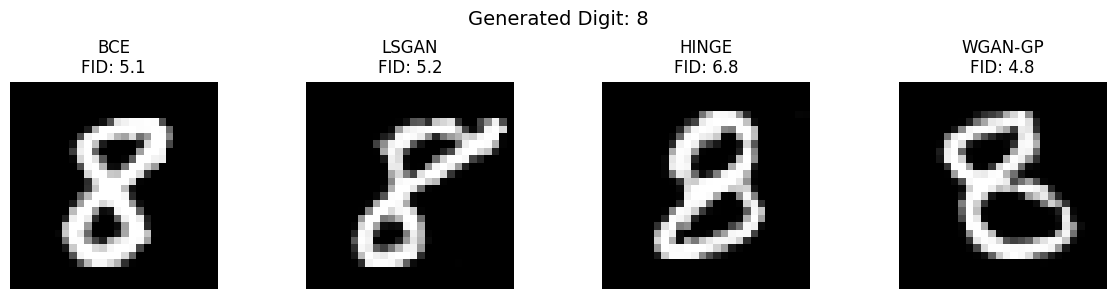

In [23]:
# Specify a digit from 0-9
digit = 8

# Use same noise for fair comparison
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([digit], device=device).long() 

fig, axes = plt.subplots(1, len(benchmark_results), figsize=(3 * len(benchmark_results), 3))

for idx, (strategy_name, data) in enumerate(benchmark_results.items()):
    g_model = Generator().to(device)
    g_model.load_state_dict(data['g_model_state'])
    g_model.eval()
    
    with torch.no_grad():
        generated = g_model(z, label)
    
    img = generated[0].cpu().numpy().reshape(28, 28)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"{strategy_name.upper()}\nFID: {data['fid']:.1f}")
    axes[idx].axis('off')

fig.suptitle(f"Generated Digit: {digit}", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 10.1** - Comparison of digit $8$ generated by each loss strategy using the same noise vector $z$. This demonstrates how different adversarial objectives produce visually distinct outputs from identical latent input.

# 11. "GAN vs. Human" Game

---

![GAN game](images/gan_game.png)

**Figure 11.1** - GAN vs Human: An interactive qualitative evaluation.

To complement the quantitative evaluation (FID, KID, class-consistency) and qualitative sample grids, we developed an interactive human-in-the-loop evaluation interface. The “GAN vs Human” is a game implemented as a Web application that provides an intuitive and engaging way to assess the perceptual realism and class-conditional control of the best-performing Generator (selected from the benchmark, the best WGAN-GP model) and a Classifier, trained in our previous MNIST project.

During the project evaluation period, we made available the "GAN vs. Human" game online at https://logus2k.com/gan, allowing any users to experiment with the trained models and experience the evaluation setup firsthand.

In this interface, a target digit (0–9) can be selected randomly by the game, or manually, by the user. Then, the Generator produces a synthetic MNIST digit conditioned on the chosen label, while user attempts to draw a more convincing MNIST digit. Both the generated sample and the user digit are subsequently evaluated by a previously trained MNIST classifier, which assigns a confidence score for the selected target class. The winner of each round is determined by which input (GAN or human) achieved the higher classifier confidence for the selected digit. Alternatively, instead of competing against the Generator, the user has the option to compete against real MNIST database digits.

To further increase this challenge's interest, the game proposes three difficulty levels, by including a time pressure:

- Basic: the user has 2.0 seconds to draw the selected digit;
- Average: the user has 1.0 second to complete the drawing;
- Pro: the user has only 0.5 seconds, emphasizing speed and motor precision.

These levels progressively constrain the human input quality, allowing the comparison to probe how the GAN performs relative to increasingly noisy or incomplete human drawings.

**Purpose and Evaluation Rationale**

This interactive setup serves three complementary goals:

1. Qualitative Realism Assessment
It allows direct visual comparison between GAN-generated digits and human-drawn digits, making perceptual differences immediately interpretable beyond abstract metrics such as FID or KID.

1. Conditional Control Verification
By selecting the target digit manually, the experiment verifies that the conditional generator reliably responds to class inputs in real time, reinforcing the controllability analysis presented earlier (fixed z, varying label).

1. Human vs. Model Benchmarking
The competitive framing highlights how well the generator’s outputs align with the learned decision boundaries of the classifier. In several trials, the GAN achieves classifier confidence comparable to (and sometimes exceeding) that of human drawings, illustrating that the generator has internalized salient class-discriminative features of MNIST.

The “GAN vs Human” game provides an intuitive and communicative demonstration of the generator’s capabilities, complementing the formal benchmarking results and offering an accessible way to showcase conditional generation performance to both technical and non-technical audiences.

# 12. Limitations

---

Despite the strong empirical results achieved in this project, particularly with the final WGAN-GP configuration (FID = **4.79**, KID = **0.0028 ± 0.0015**, Class-Consistency = **98.90%**), several limitations remain, both methodological and conceptual. These limitations also motivate a number of promising directions for future work that could extend the project from a strong experimental implementation to a more advanced and research-oriented generative modeling framework.

### 12.1 Dataset Simplicity and Scalability

All experiments were conducted on MNIST, a low-resolution (28×28), grayscale dataset with relatively low visual complexity and limited semantic variability. While MNIST remains useful for controlled experimentation and methodological comparisons, it does not reflect the challenges encountered in higher-dimensional image generation tasks (e.g., CIFAR-10, CelebA, FFHQ). Consequently, the conclusions drawn about the relative performance of adversarial objectives may not fully generalize to more complex datasets, where architectural choices, conditioning strategies, and regularization methods interact differently.

### 12.2 Metric Bias and Domain Mismatch

FID and KID were computed using Inception features, despite Inception being trained on natural images (ImageNet) and MNIST lying far outside that domain. Although these metrics were used consistently across all models and thus remain valid for **relative comparison**, their absolute values should not be interpreted as universal indicators of perceptual realism. Similarly, the "GAN vs Human" interactive evaluation relies on a classifier trained on MNIST, which introduces a closed-loop bias: the generator is effectively evaluated against a model whose decision boundaries resemble those encountered during training. This may overestimate perceptual realism while underrepresenting human subjective judgment.

### 12.3 Objective Sensitivity and Regularization Interactions

The benchmark revealed that WGAN-GP is highly sensitive to architectural and regularization choices. Although the final configuration achieved the best quantitative results, earlier variants exhibited degraded performance due to unfavorable interactions between gradient penalty, Spectral Normalization, and Dropout. This necessitated the development of a dedicated `DiscriminatorWGAN` architecture that removes these conflicting mechanisms in favor of LayerNorm and increased capacity. This highlights that theoretically motivated objectives do not automatically translate into superior empirical performance without careful adaptation of the discriminator architecture and training dynamics.

### 12.4 Training Reproducibility and CUDA Non-Determinism

During development, significant challenges arose from CUDA non-determinism, which caused identical code with the same random seed to produce vastly different training trajectories across runs. This was resolved by enforcing deterministic behavior (`torch.backends.cudnn.deterministic = True`, `torch.backends.cudnn.benchmark = False`), but at the cost of reduced training speed. This experience underscores the importance of controlling for hardware-level randomness when reporting GAN benchmarks and highlights a often-overlooked reproducibility concern in deep learning research.

### 12.5 Limited Latent Space Interpretability

While class-controllability was verified (fixed *z*, varying label), the structure of the latent space itself was not systematically analyzed. As a result, little is known about how semantic attributes (e.g., stroke thickness, curvature, slant) are organized internally, or whether latent directions correspond to interpretable factors of variation. This limits interpretability and deeper understanding of what the generator has learned beyond class identity.

# 13. Future Work

---

Building on the strong performance of the final WGAN-GP model, several extensions could further strengthen both the scientific depth and practical relevance of the project.

### 13.1 Latent Space Analysis

Now that the generator has learned a high-quality data manifold, analyzing the geometry of its latent space becomes both feasible and informative:

- **Latent Interpolation**: Interpolating between two latent vectors for the same class can reveal whether stylistic attributes (e.g., slanted vs. upright digits, thick vs. thin strokes) change smoothly, providing insight into the continuity of the learned manifold.
- **Label Interpolation**: Although labels are discrete, interpolating between class embeddings (e.g., between ‘3’ and ‘8’) can expose how the generator behaves in ambiguous semantic regions and whether it produces meaningful hybrid shapes or collapses to dominant modes.

### 13.2 Architectural Refinements

More advanced conditioning mechanisms could be explored:

- **Projection Discriminator**: Replacing label-channel concatenation with a projection discriminator could improve class-conditional modeling by directly coupling class embeddings with discriminator features. This approach is known to scale better to higher-resolution and multi-class datasets.
- **Self-Attention Modules**: Introducing self-attention layers in the generator and discriminator (e.g., at 14×14 or 28×28 resolutions) may improve global coherence by enabling long-range spatial dependencies, which become increasingly important in more complex datasets.

### 13.3 Advanced Regularization and Training Strategies

Further stabilization techniques could be incorporated:

- **Exponential Moving Average (EMA) of Generator Weights**: Maintaining an EMA copy of the generator often leads to significantly improved FID and smoother visual quality at evaluation time.
- **Differentiable Data Augmentation (DiffAugment)**: Applying lightweight augmentations to both real and generated samples before discrimination could improve robustness and reduce overfitting, particularly when scaling to smaller datasets or higher resolutions.

### 13.4 Robustness and Diversity Evaluation

Beyond global fidelity metrics, deeper evaluation of diversity and failure modes would strengthen the analysis:

- **MS-SSIM for Intra-class Diversity**: Measuring diversity within each digit class can help detect partial mode collapse, ensuring that high class-consistency does not come at the expense of stylistic variability.
- **Boundary and Failure-Mode Analysis**: Using the classifier to probe borderline or ambiguous samples could reveal systematic weaknesses in the generator, offering insight into how decision boundaries shape generative outputs.

### 13.5 Deployment and Optimization

Finally, practical deployment aspects could be explored:

- **Model Quantization**: Evaluating the impact of 8-bit quantization on FID, inference speed, and visual quality would provide insight into deployment feasibility on resource-constrained devices.
- **ONNX Export and Cross-Platform Inference**: Exporting the generator to ONNX would enable broader usability in production or web-based applications, such as extending the “GAN vs Human” game to real-time interactive demos.

# 14. Conclusions

---

This project presented a comprehensive empirical study of conditional Generative Adversarial Networks (cGANs) for digit generation on the MNIST dataset, with a particular focus on how different adversarial loss functions influence training stability, sample fidelity, class controllability, and computational efficiency. By benchmarking BCE, LSGAN, Hinge, and WGAN-GP under a controlled experimental setup, the work provides a clear and systematic comparison of classical and modern GAN objectives within the same architectural and training framework.

The results show that WGAN-GP, when carefully adapted with a dedicated critic architecture and appropriate regularization, achieved the strongest overall performance in terms of distributional fidelity and controllability, reaching the lowest FID (4.79) and KID (0.0028 ± 0.0015), together with the highest class-consistency (98.90%). This confirms the theoretical promise of Wasserstein-based objectives when the Lipschitz constraint is enforced correctly and when architectural choices are aligned with the training objective. However, the benchmarking process also highlighted that WGAN-GP is highly sensitive to design choices and computationally expensive, requiring approximately 3.7× longer training time than the other objectives. This reinforces an important practical insight: advanced GAN objectives do not offer "plug-and-play" improvements and demand careful architectural and hyperparameter adaptation to outperform simpler alternatives.

In contrast, BCE and LSGAN emerged as strong and reliable baselines, achieving competitive fidelity, high class-consistency, and substantially lower computational cost. BCE achieved FID 5.06 with the fastest training time (495s), while LSGAN reached FID 5.22 with slightly higher class-consistency (98.46%). Both objectives consistently offered an excellent trade-off between stability, realism, and efficiency, making them highly practical choices for conditional generation in low-resolution domains. These findings underline that classical GAN losses remain highly competitive when combined with modern stabilization techniques such as TTUR, Spectral Normalization, and conditional inputs. This challenges the common assumption that more sophisticated losses are universally superior and highlights the importance of empirical validation over theoretical preference alone.

The qualitative analyses further strengthened these conclusions. Per-class diversity measurements showed that all four objectives achieved comparable intra-class variability in the final configuration, with BCE and Hinge showing slightly higher diversity for certain digits. The controllability experiments demonstrated that the models successfully disentangled style (latent code) from class identity, validating the conditional design. The interactive GAN vs Human evaluation provided an intuitive demonstration of the generator's realism, showing that the best-performing model can produce digits competitive with human-drawn samples under a trained classifier. At the same time, this experiment also exposed the limitations of classifier-based evaluation, reminding that high classifier confidence does not necessarily imply perceptual realism from a human perspective.

The comparison between cGAN and DCGAN configurations revealed that conditioning significantly improves performance for BCE (+38% FID improvement) and LSGAN (+27%), while WGAN-GP also benefits substantially (+22%). Interestingly, Hinge loss showed a slight degradation with conditioning (-7%), suggesting that margin-based objectives may not leverage label information as effectively in this architectural setting.

Overall, this work highlights three key lessons. First, the effectiveness of a GAN objective is inseparable from the surrounding training pipeline—architecture, normalization, regularization, and optimization strategy jointly determine performance. Second, empirical benchmarking is essential, as theoretical advantages do not automatically translate into superior results in practical settings. Third, even on a relatively simple dataset such as MNIST, conditional GANs exhibit rich trade-offs between fidelity, diversity, stability, and efficiency, making careful design and evaluation crucial.

These findings provide a solid foundation for extending the framework to more complex datasets and architectures, and for exploring more advanced conditioning and regularization strategies in future work.

# 15. References

---

1. Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. https://www.deeplearningbook.org/
2. PyTorch. *DCGAN Tutorial*. https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html